In [46]:
nombre = '20241023'

In [ ]:
free_memory()

Memory freed!


# Install

In [1]:
# !pip install pyvolutionary==2.4.2
# !pip install scikit_learn==1.4
!pip install pycaret
!pip install pycaret[full]
!pip install nlpaug==1.1.11
!pip install imbalanced-learn==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.9 MB/s eta 0:00:00
   ━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 75.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flask to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━

# Preload

In [2]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from numpy.linalg import svd
import requests
import json


sscaler = StandardScaler()
rscaler = RobustScaler()
mmscaler = MinMaxScaler()
mascaler = MaxAbsScaler()

le = LabelEncoder()

def lencoder(df, col, lenc=False, train=True):
    if train:
        label = le.fit_transform(df[col])
        df[col] = pd.to_numeric(label)
        return df,le
    elif lenc != False:
        label = lenc.transform(df[col])
        df[col] = pd.to_numeric(label)
        return df
    else:
        print('Nothing done')
        return df



In [3]:
def run_kfold_model (model, X,y,K=10,graph=True):
    regr = LinearRegression()
    kf = KFold(n_splits=5)
    s=1
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        print('Slice '+str(s)+' score: '+str(regr.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        scores(y_test, y_pred)
        if graph:
            plt.scatter(y_test, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
            plt.show()
        s+=1
    return(regr)

In [4]:
# def scores (model, X_train, X_test, y_test, y_pred, graph=True):
#     MAE=metrics.mean_absolute_error(y_test, y_pred)
#     MSE=metrics.mean_squared_error(y_test, y_pred)
#     RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#     CV_RMSE= (RMSE/np.average(y_test))*100
#     R2=metrics.r2_score(y_test, y_pred)
#     ACC=metrics.accuracy_score
#     REC=metrics.recall_score
#     PREC=metrics.precision_score

#     print('MAE:'+str(MAE))
#     print('MSE:'+str(MSE))
#     print('RMSE:'+str(RMSE))
#     print('CV(RMSE): '+str(CV_RMSE))
#     print('R2:'+str(R2))
#     print('Accuracy:'+str(ACC))
#     print('Recall:'+str(REC))
#     print('Precision:'+str(PREC))

#     # print('Training score: '+str(model.score(X_train, y_train))) #(Accuracy or R2)
#     # print('Test score: '+str(model.score(X_test, y_train)))
#     if graph == True:
#         plt.scatter(y_train, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
#         plt.show()

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef

def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Recall
    recall = recall_score(y_test, y_pred,average='weighted')
    print("Recall:", recall)

    # Precision
    precision = precision_score(y_test, y_pred,average='weighted')
    print("Precision:", precision)

    # F1 Score
    f1 = f1_score(y_test, y_pred,average='weighted')
    print("F1 Score:", f1)

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("MCC:", mcc)


In [6]:
import dask.dataframe as dd

In [7]:
from ast import literal_eval
def clean(x):
    return literal_eval(x)

In [8]:
pd.set_option("mode.copy_on_write", True)
pd.options.mode.copy_on_write = True

In [9]:
import math

def dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    df = pd.concat([df,tDummy],axis=1).reindex(df.index)
    return(df)

def just_dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    return(tDummy)

def just_dummies_steps(df, col, ix):
    num_chunks = math.ceil(len(df) / ix)  # Calculate number of chunks
    all_dummies = []  # Store results from each chunk

    for i in range(num_chunks):
        start = i * ix  # Starting index for the current chunk
        end = (i + 1) * ix  # Ending index for the current chunk

        chunk = df.loc[start:end-1] # Select chunk of data for the dummies
        chunk_dummies = just_dummies(chunk, col)  # Apply just_dummies to chunk
        all_dummies.append(chunk_dummies)  # Append the output to the list

    # Concatenate all dummy DataFrames horizontally
    final_dummies = pd.concat(all_dummies, axis=1)
    return final_dummies

In [10]:
def columns_with_nan(df):
    # Obtener una lista de los nombres de las columnas
    columns = df.columns.to_list()

    # Filtrar las columnas que tienen valores NaN
    columns_with_nan = [col for col in columns if df[col].isna().any()]

    return columns_with_nan

def rows_with_nan(df, column_name):
    # Filtrar las filas donde la columna especificada tiene valores NaN
    rows_with_nan = df[df[column_name].isna()]
    return rows_with_nan

In [11]:
import gc

def free_memory():
    # Variables used in initial data loading and NLP
    variables_to_delete = [
        'data', 'exploded', 'exploded_filtered', 'checkit', 'checkot', 'checket',
        'wordlst', 'over1', 'tfidf_Psummary', 'tfidf_Pdescription', 'mwe_tokenizer',
        'tokenizer', 'stop_words', 'lemmatizer', 'text', 'tokenised',
        'retokenised', 'normalised', 'unmarked', 'filtered', 'lemmatised'
    ]

    # Variables used for model training and evaluation
    variables_to_delete.extend([
        'dataHM', 'datarf',  'dataset', 'X', 'Y', 'X_train', 'X_test',
        'y_train', 'y_test', 'dtrain', 'dtest', 'output', 'y_pred',
        'clf1', 'best_model', 'tuned_model', 'model', 'rf_model',
        'params', 'accuracy', 'grid_search',  'evolution', 'result',
        'ros', 'X_ros', 'y_ros', 'rus', 'X_rus', 'y_rus', 'smote', 'X_smote',
        'y_smote', 'adasyn', 'X_adasyn', 'y_adasyn', 'smoteenn', 'X_smoteenn',
        'y_smoteenn', 'class_names','correlations','selected_features'
    ])


    # Delete the variables
    for var in variables_to_delete:
        if var in globals():  # Check if variable exists
            del globals()[var]

    # Run garbage collection
    gc.collect()

    print("Memory freed!")

# Checkpoint 1 Get data

In [ ]:
# data = pd.read_excel('mozilla-bugs-all.xlsx')
# data.describe

In [ ]:
def json_data(URL,params):
    headers = {"Accept" : "application/json"}
    resp = requests.get(URL, params= params, headers= headers)
    df = pd.DataFrame()
    if resp.status_code != 200:
        print('error: ' + str(resp.status_code))
    else:
        print('Success')
        bugs = resp.text
        data = json.loads(bugs)
        df = pd.json_normalize(data['bugs'])
    return(df)

params ={
    "include_fields" : ["id"
                        ,"summary"
                        ,"status"
                        ,"description"
                        ,"type"
                        ,"classification"
                        ,"product"
                        ,"component"
                        ,"priority"
                        ,"assigned_to"
                        ,"resolution"
                        ,"creation_time"
                        ,"last_change_time"
                        ,"severity"
                        ,"version"
                        ]
    ,"product" : "Core"
    ,"severity" : ["S1"]
    # ,"status" : ["VERIFIED","RESOLVED","CLOSED","UNCONFIRMED","NEW"]
    ,"limit" : 1000
    ,"order": "opendate DESC"
}
URL = "https://bugzilla.mozilla.org/rest/bug"


In [ ]:
params["status"] = "RESOLVED"
params.pop("status", None)

test_df = json_data(URL,params)
print(test_df.columns.to_list())
test_df.tail()

Success
['priority', 'version', 'last_change_time', 'assigned_to', 'description', 'severity', 'classification', 'summary', 'status', 'product', 'creation_time', 'id', 'component', 'resolution', 'type', 'assigned_to_detail.email', 'assigned_to_detail.real_name', 'assigned_to_detail.id', 'assigned_to_detail.nick', 'assigned_to_detail.name']


,priority,version,last_change_time,assigned_to,description,severity,classification,summary,status,product,creation_time,id,component,resolution,type,assigned_to_detail.email,assigned_to_detail.real_name,assigned_to_detail.id,assigned_to_detail.nick,assigned_to_detail.name
190,P1,unspecified,2020-05-18T19:14:56Z,docfaraday@gmail.com,This bug is for crash report bp-357d3ef4-a78d-...,S1,Components,Crash in [@ mozilla::MozPromise<T>::Private::R...,VERIFIED,Core,2020-05-08T22:47:46Z,1636615,Audio/Video: Playback,FIXED,defect,docfaraday@gmail.com,Byron Campen [:bwc],478411,bwc,docfaraday@gmail.com
191,P2,78 Branch,2020-07-15T02:09:47Z,nobody@mozilla.org,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,S1,Components,meet.google.com takes 10 seconds until others ...,RESOLVED,Core,2020-05-08T22:42:53Z,1636614,WebRTC: Audio/Video,FIXED,defect,nobody@mozilla.org,Nobody; OK to take it and work on it,1,nobody,nobody@mozilla.org
192,P1,76 Branch,2020-06-29T21:02:04Z,nobody@mozilla.org,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,S1,Components,nsIPKCS11ModuleDB.addModule failure in 76+ (Es...,RESOLVED,Core,2020-05-07T12:32:32Z,1636100,Security: PSM,DUPLICATE,defect,nobody@mozilla.org,Nobody; OK to take it and work on it,1,nobody,nobody@mozilla.org
193,--,75 Branch,2020-06-17T07:11:27Z,zibi@braniecki.net,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,S1,Components,Context menus are blank on macOS,RESOLVED,Core,2020-04-11T17:56:55Z,1629291,Internationalization,FIXED,defect,zibi@braniecki.net,Zibi Braniecki [:zbraniecki][:gandalf],41270,zbraniecki,zibi@braniecki.net
194,P1,unspecified,2022-04-18T19:22:12Z,acreskey@mozilla.com,While looking at profiles generated as part of...,S1,Components,Determine if we are indeed spending up to 3x a...,RESOLVED,Core,2019-09-23T18:20:19Z,1583298,Performance,WORKSFORME,task,acreskey@mozilla.com,Andrew Creskey [:acreskey],624474,acreskey,acreskey@mozilla.com


In [ ]:
# for i in test_df.columns.to_list():
#     print("Column "+i+" unique values:")
#     # print(test_df[i].unique())
#     print(test_df[i].value_counts())

#     print()


In [ ]:
# test_df.groupby(['resolution']).sum().plot(kind='pie', y='id', autopct='%1.0f%%', labeldistance=None)
# from datetime import datetime
import csv

# print(test_df['creation_time'].min())
# datetime.now() - pd.to_datetime(pd.to_datetime(test_df['creation_time'][test_df['resolution']=='FIXED']).values.astype(np.int64).mean())
# plt.pie(x=test_df['resolution'].unique(), labels=test_df['resolution'].value_counts())
# plt.show()

# plt.title('Category Distribution')
# plt.ylabel('')  # Hide the y-label
# plt.show()

# test_df.to_csv("dataset_20241023.csv")
test_df.to_csv("dataset_"+nombre+".csv", escapechar='\\', quoting=csv.QUOTE_NONNUMERIC)


# test_df.date = pd.to_datetime(test_df.date).values.astype(np.int64)

# test_df = pd.DataFrame(pd.to_datetime(test_df.groupby('column').mean().date))

# Checkpoint 2 NLP

In [ ]:
data = pd.read_csv('dataset_'+nombre+'.csv', index_col = 'id')
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
unnamed_cols = [col for col in data.columns if col.startswith('index')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,last_change_time,priority,product,resolution,severity,status,summary,type,version,nid
id,,,,,,,,,,,,,,,,,,,,
1809860,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,"3 crashes from 2 installations, both macOS Fir...",2023-01-20T13:42:32Z,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,0
1809985,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,This will be wmfme only test.,2023-01-18T09:58:01Z,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,1
1810396,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,Crash report: https://crash-stats.mozilla.org/...,2023-06-14T16:36:00Z,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,2
1810421,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,2023-09-02T02:24:07Z,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,3
1810536,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,According to this [search](https://crash-stats...,2023-10-18T03:37:21Z,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,4


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.stem import WordNetLemmatizer
import nlpaug.augmenter.word as naw
import math
import re

def NLProcess (text):

    # print('Original text: ',data.iloc[1]['description'])
    #print("====================== starting ======================")
    ######################################################################### Tokenised
    mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
    tokenizer = word_tokenize
    tokenised = tokenizer(text)
    #print('Tokenised: ',tokenised)
    retokenised = mwe_tokenizer.tokenize(tokenised)
    # retokenised = [token.replace('_', '') for token in retokenised]
    #print('ReTokenised: ',retokenised)

    ######################################################################### Lower-case converted
    normalised = [word.lower() for word in retokenised]
    #print('Normalised: ',normalised)

    ######################################################################### Punctuation marks removed
    unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
    #print('Punctuation marks removed: ',unmarked)

    ######################################################################### Stop-words removed
    stop_words = set(stopwords.words('english'))
    filtered = [word for word in unmarked if word not in stop_words]
    #print('Stop-words removed: ',filtered)

    ######################################################################### Lemmatised
    lemmatizer = WordNetLemmatizer()
    lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
    #print('Lemmatised: ',lemmatised)

    ######################################################################### Augmented
    # aug = naw.SynonymAug(aug_src='wordnet')
    # augmented = [aug.augment(word) for word in lemmatised]
    # augmented = [item for sublist in augmented for item in sublist] #flattening here
    # #print('Augmented: ',augmented)

    return lemmatised


In [ ]:
# def dfNLProcess (df,column):
#     for index, row in df.iterrows():
#         text = row[column]
#         # print('Original text: ',data.iloc[1]['description'])
#         #print("====================== starting ======================")
#         ######################################################################### Tokenised
#         mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
#         tokenizer = word_tokenize
#         tokenised = tokenizer(text)
#         #print('Tokenised: ',tokenised)
#         retokenised = mwe_tokenizer.tokenize(tokenised)
#         # retokenised = [token.replace('_', '') for token in retokenised]
#         #print('ReTokenised: ',retokenised)

#         ######################################################################### Lower-case converted
#         normalised = [word.lower() for word in retokenised]
#         #print('Normalised: ',normalised)

#         ######################################################################### Punctuation marks removed
#         unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
#         #print('Punctuation marks removed: ',unmarked)

#         ######################################################################### Stop-words removed
#         stop_words = set(stopwords.words('english'))
#         filtered = [word for word in unmarked if word not in stop_words]
#         #print('Stop-words removed: ',filtered)

#         ######################################################################### Lemmatised
#         lemmatizer = WordNetLemmatizer()
#         lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
#         #print('Lemmatised: ',lemmatised)

#         lemmatised
#         ncol = 'P'+col
#         df2 = pd.DataFrame({ncol:lemmatised})
#         df2 = dummies(df2)


In [ ]:
# dfNLProcess(data,'summary')

In [ ]:
# for i in range(10):
#     NLProcess(data.iloc[i]['description'])

data['Psummary'] = data['summary'].map(NLProcess)

# type(data['summary'])

In [ ]:
# data['Pdescription'] = data['description'].fillna('').map(NLProcess)

In [ ]:
#data.loc[data['description'].str.contains('//crash-stats.mozilla.org/report/index/768c5c44-57c5-4746-890c-9af820240811', case=False, na=False)]

In [ ]:
data.head()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,...,priority,product,resolution,severity,status,summary,type,version,nid,Psummary
id,,,,,,,,,,,,,,,,,,,,,
1809860,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,"3 crashes from 2 installations, both macOS Fir...",...,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,0,"[crash, mozilla, maybe, emplace, webrtc, video..."
1809985,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,This will be wmfme only test.,...,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,1,"[wmfme, add, test, bug, 1808804, create, brows..."
1810396,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,Crash report: https://crash-stats.mozilla.org/...,...,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,2,"[crash, mozilla, checkedint, value]"
1810421,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,3,"[lag, spike, every, 56, second, window, locati..."
1810536,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,According to this [search](https://crash-stats...,...,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,4,"[crash, http3, code]"


In [ ]:
data = data.reset_index()
data.to_csv("dataset_"+nombre+"_plusP.csv")

# Checkpoint 3 Psummary

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Psummary': clean}, index_col = 'id') #
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.tail()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,...,priority,product,resolution,severity,status,summary,type,version,nid,Psummary
id,,,,,,,,,,,,,,,,,,,,,
11021,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2024-08-02T12:18:18Z,**Found in**\n* 129.0 RC2\n\n**Affected versio...,...,P1,Core,FIXED,S1,VERIFIED,[Windows] Videos on Hulu fail to play,defect,Trunk,11021,"[window, video, hulu, fail, play]"
11022,tziade@mozilla.com,tziade@mozilla.com,385707,tziade@mozilla.com,tarek,Tarek Ziadé (:tarek),Components,Machine Learning,2024-08-05T07:15:57Z,I tried the feature in a beta simul and it fai...,...,P1,Core,FIXED,S1,RESOLVED,ML Fails in non-debug mode because of maxLogLe...,defect,unspecified,11022,"[ml, fails, nondebug, mode, maxloglevelpref]"
11023,earo@mozilla.com,earo@mozilla.com,318883,earo@mozilla.com,eemeli,Eemeli Aro [:eemeli],Components,Internationalization,2024-09-06T07:12:19Z,The earlier update of the `unic-langid` and `u...,...,P1,Core,FIXED,S1,VERIFIED,Browser considers Saraiki (skr) as LTR rather ...,defect,Firefox 130,11023,"[browser, considers, saraiki, skr, ltr, rather..."
11024,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2024-09-20T15:34:31Z,Setup:\n- Have `media.wmf.media-engine.enabled...,...,P1,Core,FIXED,S1,RESOLVED,Hulu is not playing in Nightly on Windows Machine,defect,unspecified,11024,"[hulu, playing, nightly, window, machine]"
11025,sotaro.ikeda.g@gmail.com,sotaro.ikeda.g@gmail.com,434202,sotaro.ikeda.g@gmail.com,sotaro,Sotaro Ikeda [:sotaro],Components,Graphics,2024-10-02T14:23:09Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,P1,Core,FIXED,S1,VERIFIED,VR180 and 360 YouTube videos not working in Fi...,defect,Firefox 131,11025,"[vr180, 360, youtube, video, working, firefox,..."


In [ ]:
# from sklearn.feature_selection import mutual_info_classif

In [ ]:
type(data.iloc[0]['Psummary'])
# type(data['Psummary'])

list

In [ ]:
exploded = data.explode('Psummary')#.explode('Psummary')

In [ ]:
filter=r'^\d+$'
notfilter=r'^(?!'+filter.replace('^','')+').*$'
mask = exploded['Psummary'].str.contains(notfilter, regex=True)
exploded_filtered = exploded.loc[mask]
# exploded_filtered = exploded.loc[exploded['Psummary'].str.contains(notfilter)]

In [ ]:
checkit = just_dummies(exploded_filtered,'Psummary')

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkit.head()

,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,Psummary_0px,...,Psummary_zoomed,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ
id,,,,,,,,,,,,,,,,,,,,,
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# prefix='Psummary_'
# filter=prefix+'\d+$'
# notfilter='^(?!'+filter+').*$'
# print(len(checkit.filter(regex=(notfilter)).columns.tolist()))
# # print(checkit.filter(regex=(notfilter)).columns.tolist())

In [ ]:
checkot = checkit.groupby(['id'], observed=True).sum()

In [ ]:
checkot['nid'] = checkot.index

In [ ]:
# checkot.head()

In [ ]:
checket = checkot.compute()

In [ ]:
checkit = checket.copy()
checkit = checkit.reset_index()

In [ ]:
checkit.head()

,id,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,...,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ,nid
0,1917215,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1917215
1,1855967,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1855967
2,1861267,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1861267
3,1914347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914347
4,1914430,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914430


In [ ]:
# def rowgroupbyidnex(df):
#     rows = []
#     for i in len(df):
#         rows.append(df.iloc[i].groupby(checkit.index, observed=True).sum())





In [ ]:
checkit.to_csv('dataset_'+nombre+'_plusP_Psummary.csv')

# Checkpoint 4 Out of order

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Pdescription': clean,'Psummary': clean})
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,id,severity,resolution,assigned_to,type,creation_time,status,component,priority,version,...,classification,description,summary,product,assigned_to_detail.nick,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.email,assigned_to_detail.real_name,Psummary
id,,,,,,,,,,,,,,,,,,,,,
0,1926480,--,NaN,dpalmeiro@mozilla.com,defect,2024-10-23T03:05:31Z,NEW,JavaScript Engine,--,unspecified,...,Components,IonFreeTasks cause a lot of malloc lock conten...,Consider scheduling IonFreeTask's during Idle ...,Core,denispal,621440,dpalmeiro@mozilla.com,dpalmeiro@mozilla.com,Denis Palmeiro [:denispal],"[reckon, schedule, ionfreetask, out of work, m..."
1,1926478,--,NaN,nobody@mozilla.org,defect,2024-10-23T02:49:35Z,NEW,JavaScript Engine: JIT,--,unspecified,...,Components,A lot of time spent under malloc trying to gro...,"Too much time in SetElementMegamorphic for ""co...",Core,nobody,1,nobody@mozilla.org,nobody@mozilla.org,Nobody; OK to take it and work on it,"[much, meter, setelementmegamorphic, completew..."
2,1926477,--,NaN,nobody@mozilla.org,defect,2024-10-23T02:32:21Z,NEW,JavaScript Engine: JIT,--,unspecified,...,Components,We are 3x slower than Chrome for the function ...,Calling the getter in js::jit::GetPropertyCach...,Core,nobody,1,nobody@mozilla.org,nobody@mozilla.org,Nobody; OK to take it and work on it,"[ring, getter, joule, jit, getpropertycached, ..."
3,1926476,--,NaN,wptsync@mozilla.bugs,task,2024-10-23T02:31:19Z,NEW,Audio/Video: Web Codecs,P4,unspecified,...,Components,Sync web-platform-tests PR 48766 into mozilla-...,[wpt-sync] Sync PR 48766 - Bump maximum video ...,Core,wpt-sync,611017,wptsync@mozilla.bugs,wptsync@mozilla.bugs,Web Platform Test Sync Bot [:wpt-sync] (Matrix...,"[wptsync, sync, praseodymium, 48766, jut, uppe..."
4,1926474,--,NaN,nobody@mozilla.org,defect,2024-10-23T02:17:01Z,NEW,JavaScript Engine,--,unspecified,...,Components,Inflating the strings to UTF16 is causing a lo...,Inflating strings during JSRope::flatten is ca...,Core,nobody,1,nobody@mozilla.org,nobody@mozilla.org,Nobody; OK to take it and work on it,"[inflate, drawstring, jsrope, flatten, make, m..."


In [ ]:
exploded = data.explode('Pdescription')
filter='^\d+$'
notfilter='^(?!'+filter+').*$'

exploded = exploded.loc[exploded['Pdescription'].notna()]

exploded_filtered = exploded.loc[exploded['Pdescription'].str.contains(notfilter)]

KeyError: 'Pdescription'

In [ ]:
exploded_filtered['nindex'] = exploded_filtered.index

In [ ]:
exploded_filtered = exploded_filtered.reset_index()

In [ ]:
checkit = just_dummies_steps(exploded_filtered[['nindex','Pdescription']],'Pdescription',1000)

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkot = checkit.groupby([checkit.index], observed=True).sum()
checkot['nindex'] = checkot.index
checket = checkot.compute()
checkit = checket.reset_index()
checkit.to_csv('dataset_'+nombre+'_plusP_Pdescription.csv')

# Checkpoint 5 TFIDF

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Psummary': clean}, index_col='id') #it comes out of step 2 and it's NLP
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,...,priority,product,resolution,severity,status,summary,type,version,nid,Psummary
id,,,,,,,,,,,,,,,,,,,,,
1809860,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,"3 crashes from 2 installations, both macOS Fir...",...,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,0,"[crash, mozilla, maybe, emplace, webrtc, video..."
1809985,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,This will be wmfme only test.,...,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,1,"[wmfme, add, test, bug, 1808804, create, brows..."
1810396,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,Crash report: https://crash-stats.mozilla.org/...,...,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,2,"[crash, mozilla, checkedint, value]"
1810421,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,3,"[lag, spike, every, 56, second, window, locati..."
1810536,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,According to this [search](https://crash-stats...,...,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,4,"[crash, http3, code]"


In [ ]:
summary = pd.read_csv('dataset_'+nombre+'_plusP_Psummary.csv', index_col='id')
unnamed_cols = [col for col in summary.columns if col.startswith('Unnamed')]
summary = summary.drop(unnamed_cols,axis=1)
summary.index.name = 'id'
summary.head()


,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,Psummary_0px,...,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ,nid
id,,,,,,,,,,,,,,,,,,,,,
1917215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1917215
1855967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1855967
1861267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1861267
1914347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914347
1914430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914430


In [ ]:
data['Psummary']=data['Psummary'].tolist()

In [ ]:
# data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

def tfidf(df,col):
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform(df[col])
  rows = len(df)

  # Select the first five documents from the data set
  tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
  tf_idf.columns = vectorizer.get_feature_names_out()
  tfidf_matrix = tf_idf.T
  tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, rows+1)]
  tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

  # Top words
  tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

  # Print the first 10 words
  # print(tfidf_matrix.drop(columns=['count']).head(10))

  return tfidf_matrix


In [ ]:
# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

In [ ]:
# filter='^\d+$'
# notfilter='^(?!'+filter+').*$'
# wordlst = over1.loc[over1.index.str.contains(notfilter)]
filter=r'^\d+$'
notfilter=r'^(?!'+filter.replace('^','')+').*$'
mask = over1.index.str.contains(notfilter, na=False, regex=True)
wordlst = over1#.loc[mask]


In [ ]:
wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

,bug1,bug2,bug3,bug4,bug5,bug6,bug7,bug8,bug9,bug10,...,bug11019,bug11020,bug11021,bug11022,bug11023,bug11024,bug11025,bug11026,count,words
intermittent,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,417.481077,Psummary_intermittent
bug,0.0,0.1146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,379.164188,Psummary_bug
tracking,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,374.650090,Psummary_tracking
single,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372.161510,Psummary_single
sync,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.360329,Psummary_sync


In [ ]:
wordlst.to_csv('dataset_'+nombre+'_plusP_Wordlst_tfidf.csv')

In [ ]:
words_to_remove = ['Psummary_e', 'Psummary_ ', 'Psummary_t', 'Psummary_r', 'Psummary_n', 'Psummary_o', 'Psummary_a', 'Psummary_s', 'Psummary_m', 'Psummary_p', 'Psummary_d', 'Psummary_h', 'Psummary_f', 'Psummary_b', 'Psummary_y', 'Psummary_j', 'Psummary_z', 'Psummary_.', "Psummary_'", 'Psummary_/']
wordlst = wordlst[~wordlst['words'].isin(words_to_remove)]

In [ ]:
# Get the common columns between summary and wordlst['words']
common_cols = list(set(summary.columns) & set(wordlst['words']))

# Filter the summary DataFrame using the common columns
summary = summary[common_cols]

summary.head()

,Psummary_disk,Psummary_flag,Psummary_0u,Psummary_response,Psummary_webcompat,Psummary_gfxfontgroup,Psummary_expand,Psummary_breaking,Psummary_pinch,Psummary_asyncpanzoomcontroller,...,Psummary_updating,Psummary_addresssanitizer,Psummary_abortsignal,Psummary_rendertexturehosts,Psummary_contenttype,Psummary_low,Psummary_reported,Psummary_qm_try,Psummary_timing,Psummary_followed
id,,,,,,,,,,,,,,,,,,,,,
1917215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1855967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1861267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1914347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1914430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
summary.tail()

,Psummary_disk,Psummary_flag,Psummary_0u,Psummary_response,Psummary_webcompat,Psummary_gfxfontgroup,Psummary_expand,Psummary_breaking,Psummary_pinch,Psummary_asyncpanzoomcontroller,...,Psummary_updating,Psummary_addresssanitizer,Psummary_abortsignal,Psummary_rendertexturehosts,Psummary_contenttype,Psummary_low,Psummary_reported,Psummary_qm_try,Psummary_timing,Psummary_followed
id,,,,,,,,,,,,,,,,,,,,,
1899018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mergeddata = pd.concat([data,summary],axis=1)
mergeddata = mergeddata.reset_index()
mergeddata.to_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv')

# Checkpoint 6 Prepare first run data

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv', index_col='id')#, converters={'Pdescription': clean,'Psummary': clean})
data = data.drop([
    'summary',
    'description',
    'Psummary',
    # 'Pdescription',
    'assigned_to',
    'assigned_to_detail.real_name',
    'assigned_to_detail.nick',
    'assigned_to_detail.name',
    'assigned_to_detail.email'
],axis=1)
data.head()

,Unnamed: 0,assigned_to_detail.id,classification,component,creation_time,last_change_time,priority,product,resolution,severity,...,Psummary_updating,Psummary_addresssanitizer,Psummary_abortsignal,Psummary_rendertexturehosts,Psummary_contenttype,Psummary_low,Psummary_reported,Psummary_qm_try,Psummary_timing,Psummary_followed
id,,,,,,,,,,,,,,,,,,,,,
1809860,0,489889,Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,2023-01-20T13:42:32Z,P1,Core,FIXED,S2,...,0,0,0,0,0,0,0,0,0,0
1809985,1,517691,Components,Audio/Video: Playback,2023-01-12T19:18:35Z,2023-01-18T09:58:01Z,P2,Core,FIXED,S2,...,0,0,0,0,0,0,0,0,0,0
1810396,2,700434,Components,Audio/Video: Playback,2023-01-16T07:44:18Z,2023-06-14T16:36:00Z,P2,Core,FIXED,S2,...,0,0,0,0,0,0,0,0,0,0
1810421,3,506442,Components,Widget: Win32,2023-01-16T10:21:37Z,2023-09-02T02:24:07Z,P2,Core,FIXED,S2,...,0,0,0,0,0,0,0,0,0,0
1810536,4,415378,Components,Networking: HTTP,2023-01-16T14:33:49Z,2023-10-18T03:37:21Z,P1,Core,FIXED,S2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
rows_with_nan(data,'severity')
print(len(data))
print(rows_with_nan(data,'severity').index)
# data.rows_with_nan(data,'Psummary')
# print(data.rows_with_nan(data,'Psummary').index)

11026
Index([1897802, 1897809, 1897914, 1897940, 1897964, 1897966, 1897979, 1897981,
       1898018, 1898019,
       ...
       1926098, 1926127, 1926194, 1926195, 1926225, 1926228, 1926280, 1926300,
       1926407, 1926414],
      dtype='int64', name='id', length=896)


In [ ]:
print(data['severity'].unique())
data.loc[data['severity']=='--'].head()
data['severity'] = data['severity'].replace('normal','S3')
data = data[data['severity'] != '--']
data = data.dropna(subset=['severity'])
print(len(data))
print(rows_with_nan(data,'severity').index)

['S2' 'S1' '--' 'S4' 'S3' nan 'normal']
5856
Index([], dtype='int64', name='id')


In [ ]:
dataset = data

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# PyCaret all

In [ ]:
from pycaret.classification import *

dataset = data

data = dataset.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
],axis=1)

clf1 = setup(data, target='severity',
            use_gpu=True  # Enable GPU acceleration
            # , session_id=123
            )

# Compare models
best_model = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,123
1,Target,severity
2,Target type,Multiclass
3,Target mapping,"S1: 0, S2: 1, S3: 2, S4: 3"
4,Original data shape,"(5856, 3506)"
5,Transformed data shape,"(5856, 3506)"
6,Transformed train set shape,"(4099, 3506)"
7,Transformed test set shape,"(1757, 3506)"
8,Numeric features,3504
9,Categorical features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8990,0.9555,0.8990,0.9092,0.8997,0.8442,0.8486,11.7550
gbc,Gradient Boosting Classifier,0.8978,0.0000,0.8978,0.9094,0.8986,0.8425,0.8477,49.6320
xgboost,Extreme Gradient Boosting,0.8961,0.9573,0.8961,0.9061,0.8968,0.8400,0.8443,16.0380
catboost,CatBoost Classifier,0.8946,0.9548,0.8946,0.9058,0.8952,0.8377,0.8427,18.8680
lightgbm,Light Gradient Boosting Machine,0.8907,0.9568,0.8907,0.8980,0.8914,0.8318,0.8347,9.4750
et,Extra Trees Classifier,0.8866,0.9497,0.8866,0.8955,0.8871,0.8251,0.8287,13.9320
dt,Decision Tree Classifier,0.8714,0.8995,0.8714,0.8737,0.8717,0.8026,0.8033,9.6700
ada,Ada Boost Classifier,0.8614,0.0000,0.8614,0.8833,0.8594,0.7853,0.7992,13.4660
lr,Logistic Regression,0.8231,0.0000,0.8231,0.8356,0.8206,0.7295,0.7342,83.6600
ridge,Ridge Classifier,0.7592,0.0000,0.7592,0.7623,0.7576,0.6289,0.6304,10.7610


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(best_model)

NameError: name 'tune_model' is not defined

In [ ]:
evaluate_model(tuned_model)

# READ and prepare

In [80]:
data = pd.read_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv', index_col='id')#, converters={'Pdescription': clean,'Psummary': clean})
data = data.drop([
    'assigned_to'
    ,'assigned_to_detail.nick'
    ,'assigned_to_detail.name'
    ,'assigned_to_detail.email'
    ,'assigned_to_detail.real_name'
    ,'product'
    ,'classification'
    ,'creation_time'
    ,'last_change_time'
    ,'priority'
    ,'resolution'
    ,'type'
    # ,'status'
    ,'summary'
    ,'description'
    ,'Psummary'
    #,'Pdescription'

],axis=1)
data.head()

,Unnamed: 0,severity,status,component,version,assigned_to_detail.id,Psummary_usercharacteristics,Psummary_lowering,Psummary_access,Psummary_bar,...,Psummary_live,Psummary_csscssvariablesvariablecsswidekeywordshtml,Psummary_foundation,Psummary_gmail,Psummary_xsimd,Psummary_connection,Psummary_unsafe,Psummary_structs,Psummary_nstarray_base,Psummary_forkserver
id,,,,,,,,,,,,,,,,,,,,,
1926480,0,--,NEW,JavaScript Engine,unspecified,621440,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926478,1,--,NEW,JavaScript Engine: JIT,unspecified,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926477,2,--,NEW,JavaScript Engine: JIT,unspecified,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926476,3,--,NEW,Audio/Video: Web Codecs,unspecified,611017,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926474,4,--,NEW,JavaScript Engine,unspecified,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
rows_with_nan(data,'severity')
print(len(data))
print(rows_with_nan(data,'severity').index)
# data.rows_with_nan(data,'Psummary')
# print(data.rows_with_nan(data,'Psummary').index)

10000
Index([1926414, 1926407, 1926300, 1926280, 1926228, 1926225, 1926195, 1926194,
       1926127, 1926098,
       ...
       1898019, 1898018, 1897981, 1897979, 1897966, 1897964, 1897940, 1897914,
       1897809, 1897802],
      dtype='int64', name='id', length=896)


In [82]:
print(data['severity'].unique())
data.loc[data['severity']=='--'].head()
data['severity'] = data['severity'].replace('normal','S3')
data = data[data['severity'] != '--']
data = data.dropna(subset=['severity'])
print(len(data))
print(rows_with_nan(data,'severity').index)

['--' 'S4' 'S3' 'S2' nan 'S1' 'normal']
4826
Index([], dtype='int64', name='id')


In [83]:
dataset = data

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Metrics

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred (true and predicted labels)

def calculate_metrics(y_test, y_pred, class_names=None):
    """Calculates and prints various classification metrics."""

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix with Class Names
    cm = confusion_matrix(y_test, y_pred)

    if class_names is not None:
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(f"Confusion Matrix:\n{cm_df}")
    else:
        print(f"Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={"size": 16})  # Adjust the size here)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Calculate Specificity, Recall, Precision, F1-Score for Multi-class
    num_classes = cm.shape[0]
    specificity = []
    recall = []
    precision = []
    f1 = []

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0)

    print(f"Specificity (per class): {specificity}")
    print(f"Recall (per class): {recall}")
    print(f"Precision (per class): {precision}")
    print(f"F1-score (per class): {f1}")

  # AUC-ROC (Class-wise - for multi-class using One-vs-Rest)
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_binarized = lb.transform(y_test)
    y_pred_binarized = lb.transform(y_pred) #Corrected: using y_pred for binarization
    for i in range(y_test_binarized.shape[1]):
        auc_roc_class = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])
        print(f"AUC-ROC for class {class_names[i]}: {auc_roc_class:.4f}")
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()


In [65]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def calculate_metrics_table(y_test, y_pred, class_names=None):
    """Calculates and prints various classification metrics."""

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)


    # Confusion Matrix with Class Names
    cm = confusion_matrix(y_test, y_pred)

    #Calculate AUCROC, Specificity, Recall, Precision, F1-Score for Multi-class
    num_classes = cm.shape[0]
    auc_roc = []
    specificity = []
    recall = []
    precision = []
    f1 = []

  # AUC-ROC (Class-wise - for multi-class using One-vs-Rest)
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_binarized = lb.transform(y_test)
    y_pred_binarized = lb.transform(y_pred) #Corrected: using y_pred for binarization

    for i in range(y_test_binarized.shape[1]):
        auc_roc_class = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])

        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        auc_roc.append(auc_roc_class)
        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0)

        # print(f"AUC-ROC for class {class_names[i]}: {auc_roc_class:.4f}")
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    # Create a list of dictionaries for each row in the table
    data = []
    for i in range(num_classes):
        data.append({
            'Class': class_names[i],
            'AUC-ROC': auc_roc[i],
            'Specificity': specificity[i],
            'Recall': recall[i],
            'Precision': precision[i],
            'F1-score': f1[i]
        })

    # Append the total/average row
    data.append({
            'Class': 'Total/Average',
            'AUC-ROC': np.mean(auc_roc),
            'Specificity': np.mean(specificity),
            'Recall': recall_score(y_test, y_pred,average='weighted'),
            'Precision': precision_score(y_test, y_pred,average='weighted'),
            'F1-score': f1_score(y_test, y_pred,average='weighted')
        })


    # Create a Pandas DataFrame for a table-like view
    metrics_df = pd.DataFrame(data)
    print(f"Overall Accuracy: {accuracy:.4f}")

    if class_names is not None:
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(f"Confusion Matrix:\n{cm_df}")
    else:
        print(f"Confusion Matrix:\n{cm}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={"size": 16})  # Adjust the size here)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()




    print(metrics_df.to_string())  # Print the DataFrame in a table-like format




# RF

In [51]:
datarf = dummies(data,'component').copy()
datarf, lemodel = lencoder(datarf,'severity')
datarf, lemodel = lencoder(datarf,'version')
datarf['assigned_to_detail.id'] = datarf['assigned_to_detail.id']

datarf = datarf.drop(['component'
    ,'status'#,'Pdescription'
    ],axis=1)

In [52]:
dataset = datarf

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model

def run_rf(X_train, y_train, X_test, y_test):
    params = {'bootstrap': True,
              'ccp_alpha': 0.0,
              'class_weight': 'balanced',
              'criterion': 'gini',
              'max_depth': 10,
              'max_features': 'sqrt',
              'max_leaf_nodes': None,
              'max_samples': None,
              'min_impurity_decrease': 0.0,
              'min_samples_leaf': 1,
              'min_samples_split': 2,
              'min_weight_fraction_leaf': 0.0,
              'monotonic_cst': None,
              'n_estimators': 300,
              'n_jobs': -1,
              'oob_score': False,
              'verbose': 0,
              'warm_start': False}

    rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)  # Adjust parameters as needed
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)
    return y_pred


Accuracy: 0.9072
Confusion Matrix:
    S1   S2   S3   S4
S1  55    4    2    1
S2   0  252   42    0
S3   0    2  649   20
S4   0    1   91  638


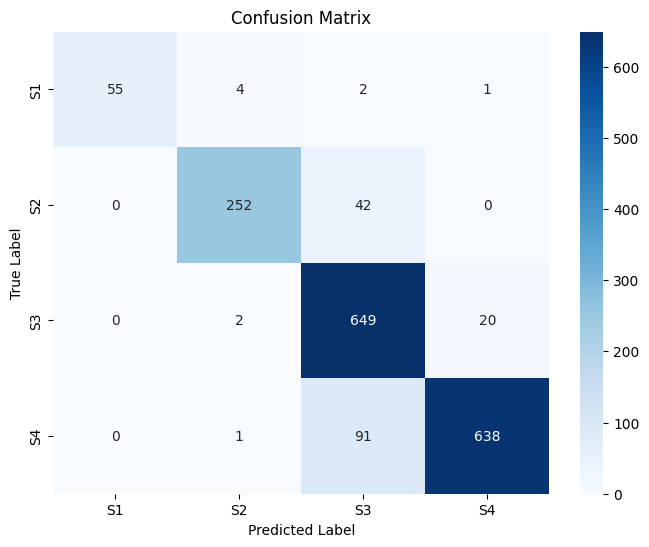

Specificity (per class): [1.0, 0.9952153110047847, 0.8756906077348067, 0.9795520934761441]
Recall (per class): [0.8870967741935484, 0.8571428571428571, 0.9672131147540983, 0.873972602739726]
Precision (per class): [1.0, 0.972972972972973, 0.8278061224489796, 0.9681335356600911]
F1-score (per class): [0.9401709401709402, 0.9113924050632912, 0.8920962199312714, 0.9186465082793377]
AUC-ROC for class S1: 0.9435
AUC-ROC for class S2: 0.9262
AUC-ROC for class S3: 0.9215
AUC-ROC for class S4: 0.9268


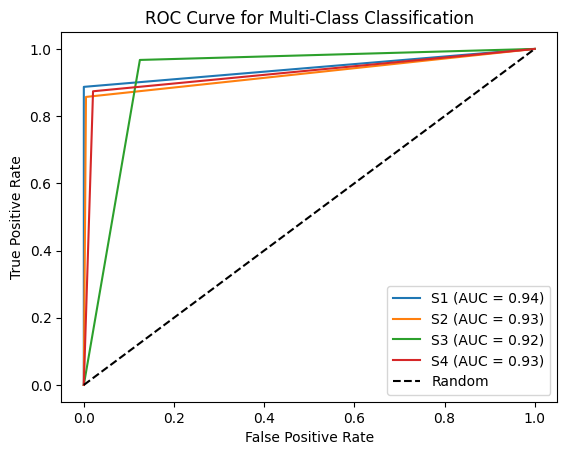

In [24]:
class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_rf(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# XGBoost

In [74]:
dataset = data

X = dataset.drop(['severity'],axis=1)

Y = dataset['severity']

cat_cols = [
'component'
,'status'
,'version'
]

for col in cat_cols:
    print(col)
    X[col] = X[col].astype('category')

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

component
status
version


In [75]:
import xgboost as xgb
from xgboost import DMatrix, XGBClassifier

def run_xgboost(X_train, y_train, X_test, y_test):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

    params = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'num_class': 4,
        'max_depth': 3,
        'subsample': 1.0,
        'colsample_bylevel': 0.6,
        'colsample_bytree': 0.8,
        'min_child_weight': 0.5,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'gamma': 0.1,
        'learning_rate': 0.2,
        'max_delta_step': 5,
        'tree_method': 'auto'
    }

    model_xgb = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            verbose_eval=100,
            evals=[(dtrain, "train")],
        )

    y_pred = model_xgb.predict(dtest)
    y_pred = y_pred.astype(int)  # Convert y_pred to integers

    scores(y_test, y_pred)
    return le.inverse_transform(y_pred)


[0]	train-mlogloss:1.11423
[99]	train-mlogloss:0.24823
Accuracy: 0.8874309392265194
Recall: 0.8874309392265194
Precision: 0.876779820513843
F1 Score: 0.8747089163782129
Cohen's Kappa: 0.7843907465533432
MCC: 0.7909949776171853
Accuracy: 0.8874
Confusion Matrix:
    S1  S2   S3   S4
S1   0   1    1    0
S2   0   2   50    0
S3   0   3  619   24
S4   0   0   84  664


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


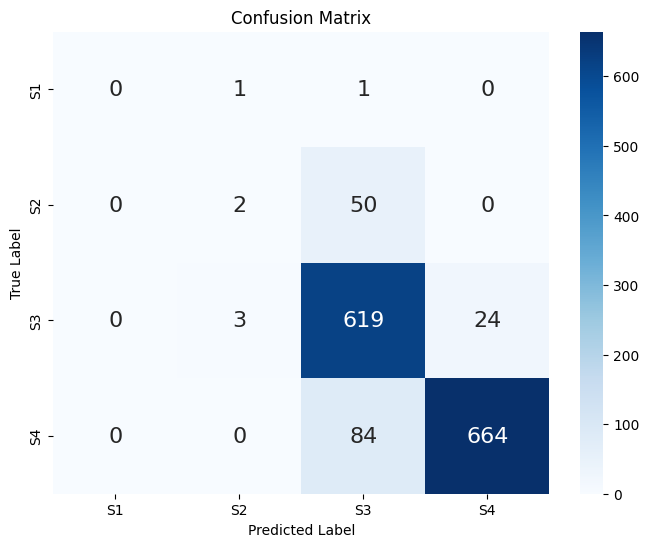

Specificity (per class): [1.0, 0.997134670487106, 0.8316708229426434, 0.9657142857142857]
Recall (per class): [0.0, 0.038461538461538464, 0.958204334365325, 0.8877005347593583]
Precision (per class): [0, 0.3333333333333333, 0.8209549071618037, 0.9651162790697675]
F1-score (per class): [0, 0.06896551724137931, 0.8842857142857142, 0.9247910863509751]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5178
AUC-ROC for class S3: 0.8949
AUC-ROC for class S4: 0.9267


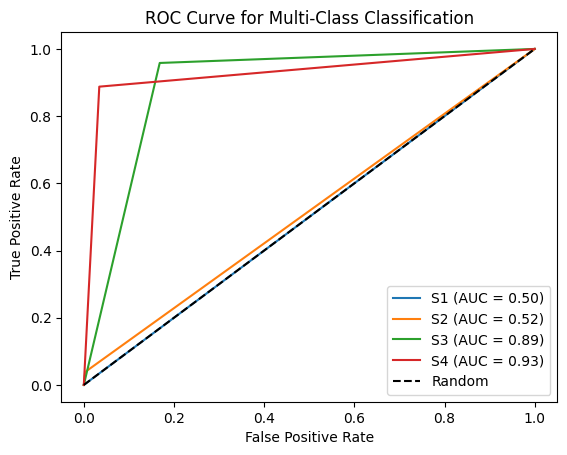

In [76]:
class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_xgboost(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# LightGBM

In [ ]:
import re

datalgbm = dummies(data,'component').copy()
datalgbm = dummies(datalgbm,'status').copy()
datalgbm, lemodel = lencoder(datalgbm,'severity')
datalgbm, lemodel = lencoder(datalgbm,'version')
datalgbm['assigned_to_detail_id'] = datalgbm['assigned_to_detail.id']
dataset = datalgbm

X = dataset.drop(['severity','status','component'],axis=1)

Y = dataset['severity']

def find_problematic_columns(df):
  """Finds columns with special characters in their names."""
  problematic_columns = []
  for column in df.columns:
    if re.search('[^A-Za-z0-9_]+', column):
      problematic_columns.append(column)
  return problematic_columns

# Find problematic columns in X_train and X_test
problematic_columns = find_problematic_columns(X)
X = X.drop(problematic_columns, axis=1)

In [ ]:
# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Accuracy: 0.9072
Confusion Matrix:
    S1   S2   S3   S4
S1  56    4    2    0
S2   0  252   42    0
S3   0    0  660   11
S4   0    0  104  626


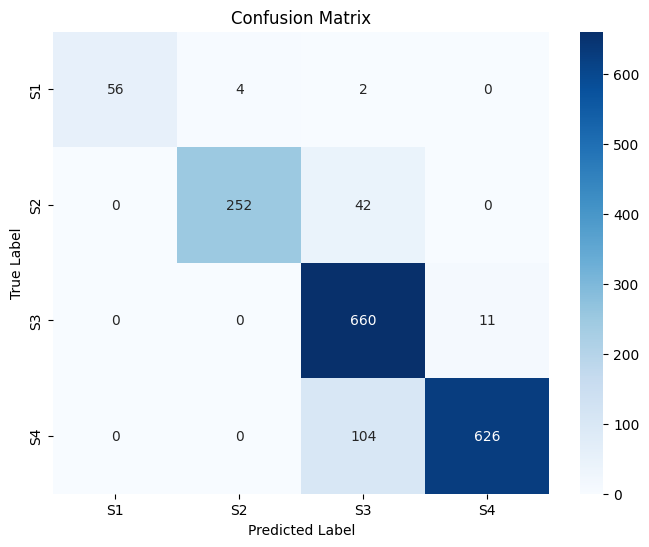

Specificity (per class): [1.0, 0.9972658920027341, 0.8637200736648251, 0.9892891918208374]
Recall (per class): [0.9032258064516129, 0.8571428571428571, 0.9836065573770492, 0.8575342465753425]
Precision (per class): [1.0, 0.984375, 0.8168316831683168, 0.9827315541601256]
F1-score (per class): [0.9491525423728813, 0.9163636363636364, 0.8924949290060851, 0.9158741770299926]
AUC-ROC for class S1: 0.9516
AUC-ROC for class S2: 0.9272
AUC-ROC for class S3: 0.9237
AUC-ROC for class S4: 0.9234


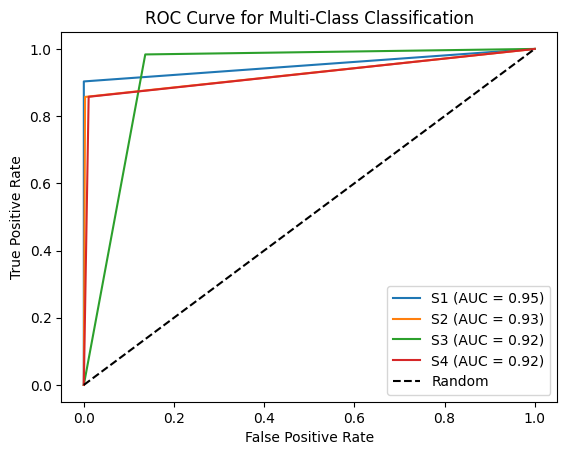

In [ ]:
import lightgbm as lgb
from lightgbm import early_stopping
import numpy as np


def run_lightgbm(X_train, y_train, X_test, y_test):

    params = {
        'objective': 'multiclass',  # Example for binary classification
        'boosting_type': 'gbdt',
        'metric': ['multi_logloss', 'multi_error'], # Multiple metrics for optimization
        'num_class': 4,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'num_leaves': 31,
        'max_depth': 5,
        'min_data_in_leaf': 20,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 10,
        'verbose': -1  # Suppress output
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model
    model = lgb.train(params, train_data, valid_sets=[test_data],
                      # verbose_eval=False
                      )

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    # Use argmax to get the class with the highest probability
    y_pred = np.argmax(y_pred, axis=1)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    # report = classification_report(y_test, y_pred)

    # print(f"Accuracy: {accuracy:.4f}")
    # print(report)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_lightgbm(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# CATBoost

In [84]:
import re

datacat = dummies(data,'component').copy()
datacat = dummies(datacat,'status').copy()
datacat, lemodel = lencoder(datacat,'severity')
datacat, lemodel = lencoder(datacat,'version')
datacat['assigned_to_detail_id'] = datacat['assigned_to_detail.id']
dataset = datacat

X = dataset.drop(['severity','status','component'],axis=1)

Y = dataset['severity']

def find_problematic_columns(df):
  """Finds columns with special characters in their names."""
  problematic_columns = []
  for column in df.columns:
    if re.search('[^A-Za-z0-9_]+', column):
      problematic_columns.append(column)
  return problematic_columns

# Find problematic columns in X_train and X_test
problematic_columns = find_problematic_columns(X_train)
X = X.drop(problematic_columns, axis=1)

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8874
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   0   52    0
S3   0   0  630   16
S4   0   0   93  655


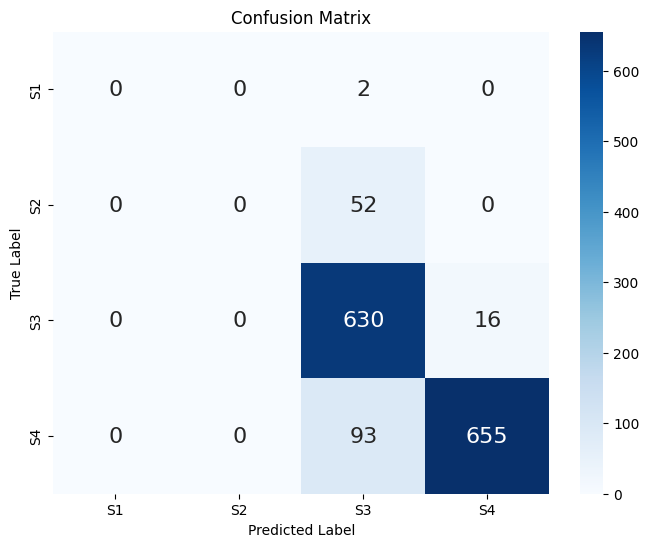

Specificity (per class): [1.0, 1.0, 0.816708229426434, 0.9771428571428571]
Recall (per class): [0.0, 0.0, 0.9752321981424149, 0.8756684491978609]
Precision (per class): [0, 0, 0.8108108108108109, 0.9761549925484352]
F1-score (per class): [0, 0, 0.8854532677442025, 0.9231853417899929]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5000
AUC-ROC for class S3: 0.8960
AUC-ROC for class S4: 0.9264


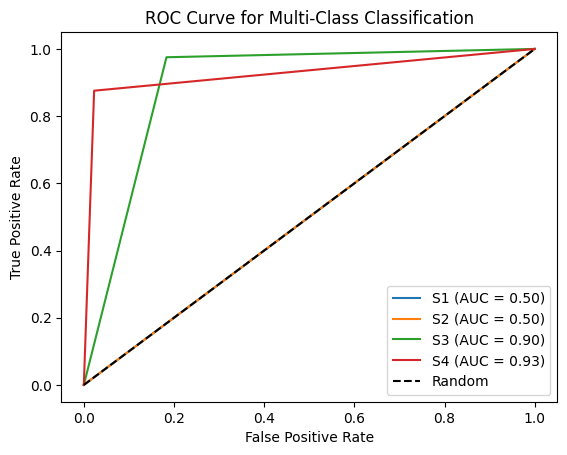

In [85]:
import catboost as cb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


def run_catboost(X_train, y_train, X_test, y_test):

    # Before creating the CatBoost Pool, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Create CatBoost Pool after ensuring y_train is in the correct format
    train_data = cb.Pool(data=X_train, label=y_train)
    test_data = cb.Pool(data=X_test, label=y_test)

    # Define model parameters
    params = {
        'iterations': 100,  # Number of boosting rounds
        'learning_rate': 0.1,  # Step size at each iteration
        'depth': 6,  # Depth of trees
        'loss_function': 'MultiClass',  # Loss function for multi-class classification
        'eval_metric': 'Accuracy',  # Evaluation metric
        'verbose': False  # Suppress training output
    }

    # Initialize and train the model
    model = cb.CatBoostClassifier(**params)
    model.fit(train_data, eval_set=test_data)

    # Make predictions
    y_pred = model.predict(test_data)
    # Convert predictions to 1D array if necessary
    y_pred = y_pred.flatten() if y_pred.ndim > 1 else y_pred

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_catboost(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


# Gradient boosting

In [ ]:
import re

datagb = dummies(data,'component').copy()
datagb = dummies(datagb,'status').copy()
datagb, lemodel = lencoder(datagb,'severity')
datagb, lemodel = lencoder(datagb,'version')
datagb['assigned_to_detail_id'] = datagb['assigned_to_detail.id']
dataset = datagb

X = dataset.drop(['severity','status','component'],axis=1)

Y = dataset['severity']

def find_problematic_columns(df):
  """Finds columns with special characters in their names."""
  problematic_columns = []
  for column in df.columns:
    if re.search('[^A-Za-z0-9_]+', column):
      problematic_columns.append(column)
  return problematic_columns

# Find problematic columns in X_train and X_test
problematic_columns = find_problematic_columns(X_train)
X = X.drop(problematic_columns, axis=1)

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.9032
Confusion Matrix:
    S1   S2   S3   S4
S1  56    4    2    0
S2   0  252   42    0
S3   4    1  653   13
S4   0    0  104  626


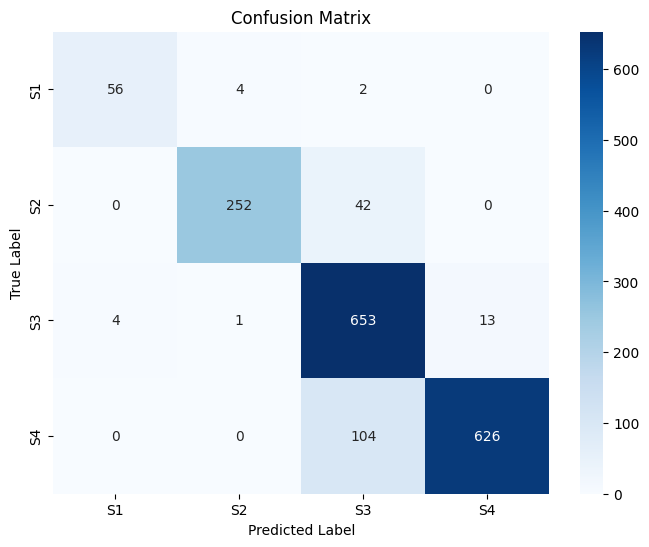

Specificity (per class): [0.9976401179941002, 0.9965823650034177, 0.8637200736648251, 0.9873417721518988]
Recall (per class): [0.9032258064516129, 0.8571428571428571, 0.9731743666169895, 0.8575342465753425]
Precision (per class): [0.9333333333333333, 0.980544747081712, 0.815230961298377, 0.9796557120500783]
F1-score (per class): [0.9180327868852459, 0.9147005444646097, 0.8872282608695653, 0.9145361577794011]
AUC-ROC for class S1: 0.9504
AUC-ROC for class S2: 0.9269
AUC-ROC for class S3: 0.9184
AUC-ROC for class S4: 0.9224


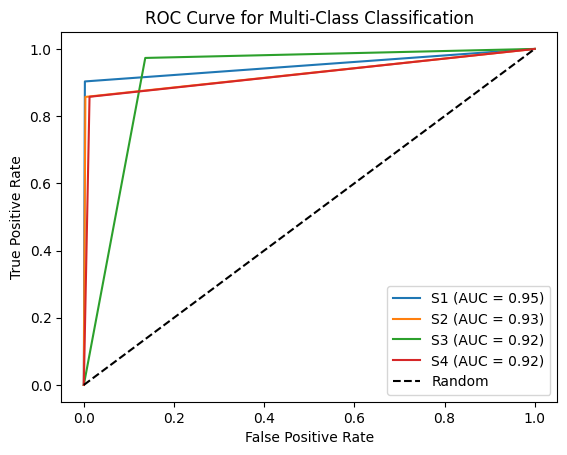

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np

def run_gradient_boosting(X_train, y_train, X_test, y_test):

    # Before training, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Initialize and train the model
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_gradient_boosting(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# Extra Trees

In [ ]:
dataet = dummies(data,'component').copy()
dataet, lemodel = lencoder(dataet,'severity')
dataet, lemodel = lencoder(dataet,'version')
dataet['assigned_to_detail.id'] = dataet['assigned_to_detail.id']

dataet = dataet.drop(['component'
    ,'status'#,'Pdescription'
    ],axis=1)

In [ ]:
dataset = dataet

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8947
Confusion Matrix:
    S1   S2   S3   S4
S1  50    4    7    1
S2   1  248   44    1
S3   0   13  631   27
S4   1    1   85  643


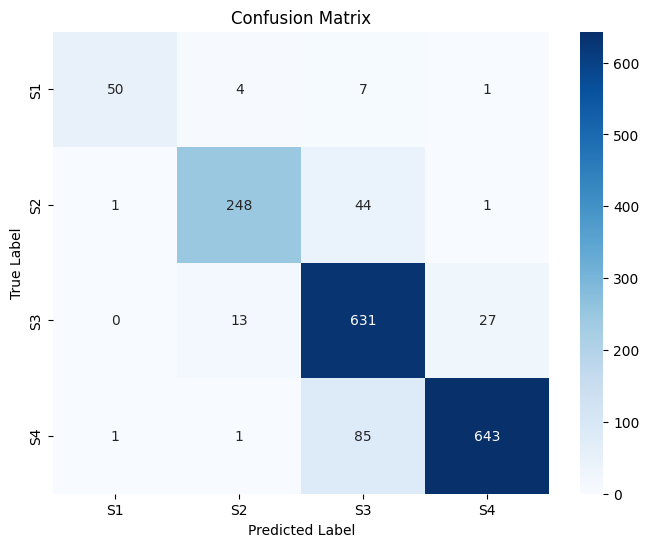

Specificity (per class): [0.9988200589970502, 0.9876965140123035, 0.8747697974217311, 0.9717624148003895]
Recall (per class): [0.8064516129032258, 0.8435374149659864, 0.940387481371088, 0.8808219178082192]
Precision (per class): [0.9615384615384616, 0.9323308270676691, 0.8226857887874837, 0.9568452380952381]
F1-score (per class): [0.8771929824561403, 0.8857142857142857, 0.8776077885952712, 0.9172610556348074]
AUC-ROC for class S1: 0.9026
AUC-ROC for class S2: 0.9156
AUC-ROC for class S3: 0.9076
AUC-ROC for class S4: 0.9263


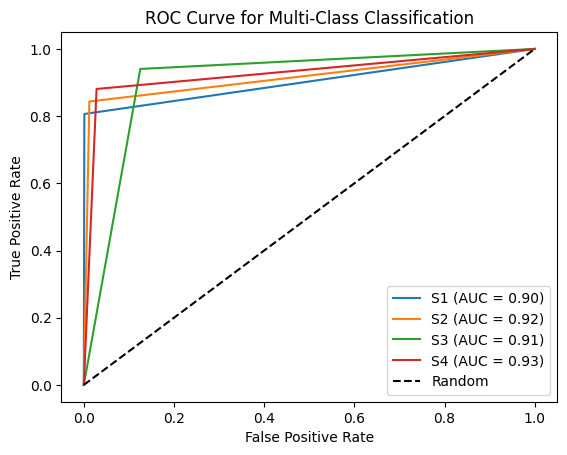

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np

def run_et(X_train, y_train, X_test, y_test):
    """
    Trains an Extra Trees Classifier model and makes predictions.

    Args:
        X_train: Training data features.
        y_train: Training data target variable.
        X_test: Testing data features.
        y_test: Testing data target variable.

    Returns:
        y_pred: Predicted target variable for the testing data.
    """

    # Before training, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Initialize and train the model
    model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_et(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# Decision Tree

In [ ]:
datadt = dummies(data,'component').copy()
datadt, lemodel = lencoder(datadt,'severity')
datadt, lemodel = lencoder(datadt,'version')
datadt['assigned_to_detail.id'] = datadt['assigned_to_detail.id']

datadt = datadt.drop(['component'
    ,'status'#,'Pdescription'
    ],axis=1)

dataset = datadt

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8600
Confusion Matrix:
    S1   S2   S3   S4
S1  55    4    3    0
S2   6  249   37    2
S3   1   39  568   63
S4   0    3   88  639


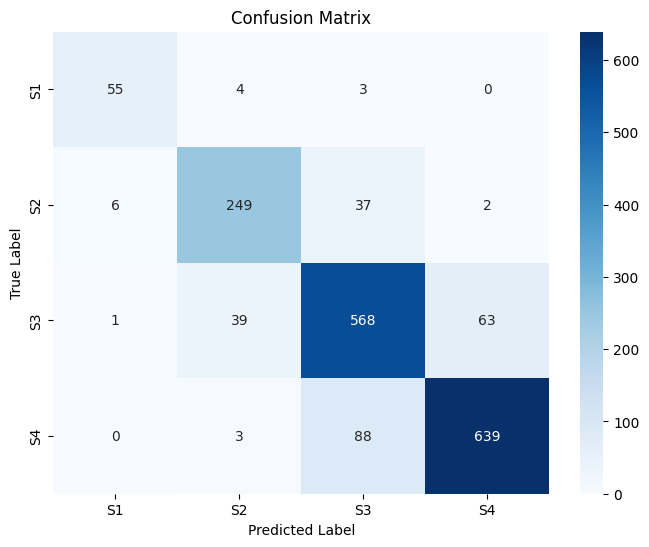

Specificity (per class): [0.9958702064896755, 0.9685577580314423, 0.8821362799263351, 0.9367088607594937]
Recall (per class): [0.8870967741935484, 0.8469387755102041, 0.8464977645305514, 0.8753424657534247]
Precision (per class): [0.8870967741935484, 0.8440677966101695, 0.8160919540229885, 0.9076704545454546]
F1-score (per class): [0.8870967741935484, 0.8455008488964347, 0.831016825164594, 0.891213389121339]
AUC-ROC for class S1: 0.9415
AUC-ROC for class S2: 0.9077
AUC-ROC for class S3: 0.8643
AUC-ROC for class S4: 0.9060


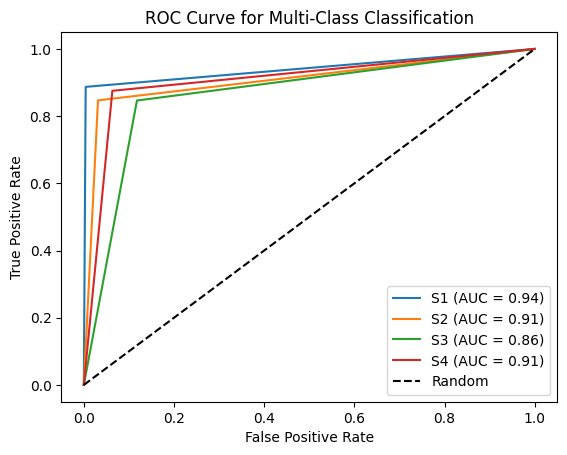

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

def run_dt(X_train, y_train, X_test, y_test):
    """
    Trains a Decision Tree Classifier model and makes predictions.

    Args:
        X_train: Training data features.
        y_train: Training data target variable.
        X_test: Testing data features.
        y_test: Testing data target variable.

    Returns:
        y_pred: Predicted target variable for the testing data.
    """

    # Before training, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Initialize and train the model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_dt(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# MLP

In [ ]:
X = data.drop('severity', axis=1)  # Replace 'target_variable' with your target column name
y = data['severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# !pip install tensorflow pandas scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras


# Preprocessing: One-hot encoding for categorical features
def preprocess_data(X_train, X_test, y_train):

    # Handle categorical features in X_train and X_test
    categorical_cols_train = X_train.select_dtypes(include=['object']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object']).columns

    # Use the same columns for one-hot encoding in both train and test
    categorical_cols = list(set(categorical_cols_train) | set(categorical_cols_test))

    X_train = pd.get_dummies(X_train, columns=categorical_cols, dummy_na=False)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, dummy_na=False)

    # Align columns to ensure they are the same in both train and test
    X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

    # Handle numerical features: Scaling
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # Convert y_train to numerical using Label Encoding
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    return X_train, X_test, y_train_encoded, label_encoder


# Building and training the MLP model
def build_and_train_mlp(X_train, y_train, num_classes, epochs=10, verbose=1): # verbose parameter added
    input_dim = X_train.shape[1]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2) # Stop if validation loss doesn't improve for 3 epochs

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=verbose, validation_split=0.3, callbacks=[early_stopping])
    return model, history

In [ ]:
def run_mlp(X_train, y_train, X_test, y_test):
    # 1. Preprocess the data:
    X_train_processed, X_test_processed, y_train_encoded, label_encoder = preprocess_data(X_train, X_test, y_train)


    # 3. Build and train the model (using strategy for GPU distribution):
    num_classes = len(label_encoder.classes_)
    desired_epochs = 15  # Set the desired number of epochs here


    # Configure TensorFlow to use GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            model, history = build_and_train_mlp(X_train_processed, y_train_encoded, num_classes, epochs=desired_epochs, verbose=2)
    else:
        model, history = build_and_train_mlp(X_train_processed, y_train_encoded, num_classes, epochs=desired_epochs, verbose=2)

    # 4. Evaluate the model:
    y_test_encoded = label_encoder.transform(y_test)  # Encode y_test using the same label encoder
    loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # 5. Make predictions (optional):
    y_pred = model.predict(X_test_processed)
    predicted_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    return model, history, X_test_processed, y_test, label_encoder, predicted_labels


model, history, X_test_processed, y_test, label_encoder, y_pred = run_mlp(X_train, y_train, X_test, y_test)
# evaluate_model(y_test, y_pred)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
45/45 - 17s - 381ms/step - accuracy: 0.6236 - loss: 20.4071 - val_accuracy: 0.6878 - val_loss: 4.1408
Epoch 2/15
45/45 - 19s - 431ms/step - accuracy: 0.8665 - loss: 2.0485 - val_accuracy: 0.7285 - val_loss: 1.5595
Epoch 3/15
45/45 - 16s - 348ms/step - accuracy: 0.9055 - loss: 1.1015 - val_accuracy: 0.7528 - val_loss: 1.3880
Epoch 4/15
45/45 - 20s - 448ms/step - accuracy: 0.9265 - loss: 0.9116 - val_accuracy: 0.7065 - val_loss: 1.3083
Epoch 5/15
45/45 - 21s - 468ms/step - accuracy: 0.9338 - loss: 0.8035 - val_accuracy: 0.7268 - val_loss: 1.2774
Epoch 6/15
45/45 - 15s - 332ms/step - accuracy: 0.9394 - loss: 0.7376 - val_accuracy: 0.7008 - val_loss: 1.2290
Epoch 7/15
45/45 - 20s - 454ms/step - accuracy: 0.9442 - loss: 0.6794 - val_accuracy: 0.6959 - val_loss: 1.2122
Epoch 8/15
45/45 - 22s - 480ms/step - accuracy: 0.9502 - loss: 0.6580 - val_accuracy: 0.7057 - val_loss: 1.2082
Epoch 9/15
45/45 - 21s - 474ms/step - accuracy: 0.9613 - loss: 0.6203 - val_accuracy: 0.6984 - val_loss

In [ ]:
from sklearn.metrics import roc_auc_score

def calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder):

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

   # Get predicted probabilities and convert to predicted labels
    y_pred_prob = model.predict(X_test_processed)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to predicted labels

    # Convert y_test to numerical labels to match y_pred
    y_test_encoded = label_encoder.transform(y_test)

    # Confusion Matrix with Class Names
    cm = confusion_matrix(y_test_encoded, y_pred)  # Use y_test_encoded and y_pred

    if class_names is not None:
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(f"Confusion Matrix:\n{cm_df}")
    else:
        print(f"Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Calculate Specificity, Recall, Precision, F1-Score for Multi-class
    num_classes = cm.shape[0]
    specificity = []
    recall = []
    precision = []
    f1 = []

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0)

    print(f"Specificity (per class): {specificity}")
    print(f"Recall (per class): {recall}")
    print(f"Precision (per class): {precision}")
    print(f"F1-score (per class): {f1}")

  # AUC-ROC (Class-wise - for multi-class using One-vs-Rest)
    lb = LabelBinarizer()
    lb.fit(y_train)
    y_test_binarized = lb.transform(y_test)
    y_pred_binarized = lb.transform(y_pred) #Corrected: using y_pred for binarization
    for i in range(y_test_binarized.shape[1]):
        auc_roc_class = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])
        print(f"AUC-ROC for class {class_names[i]}: {auc_roc_class:.4f}")
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()





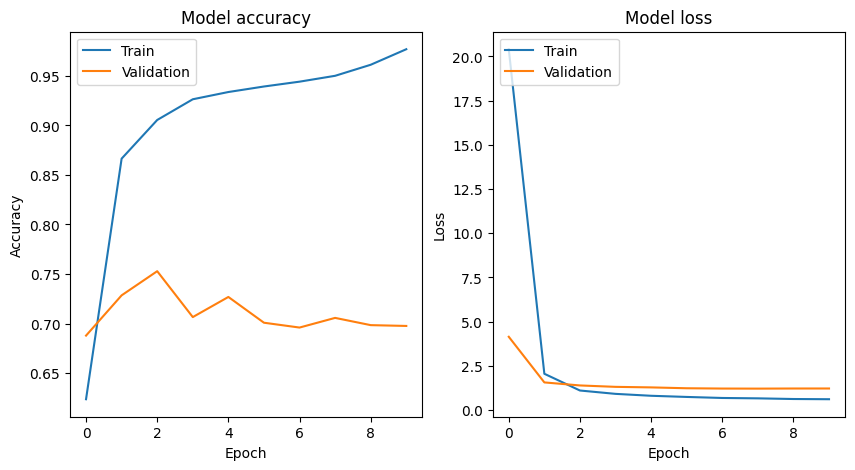

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Confusion Matrix:
    S1   S2   S3   S4
S1   9   14   30    9
S2   0  181  101   12
S3   5  154  449   63
S4   2   19   82  627


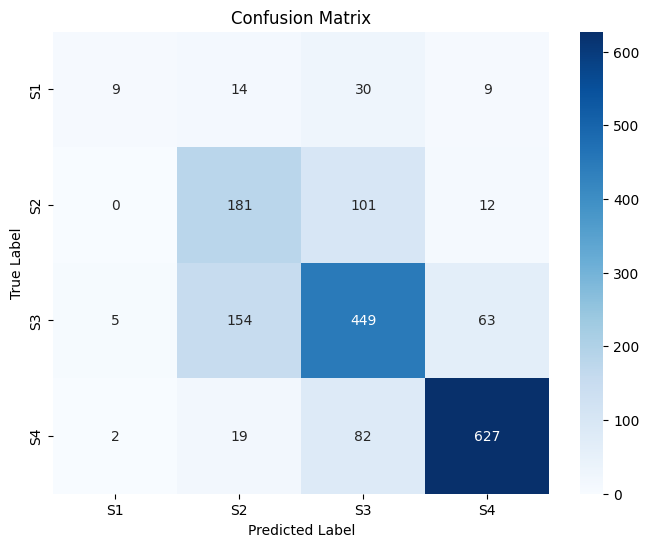

Specificity (per class): [0.9958702064896755, 0.8721804511278195, 0.8038674033149171, 0.9182083739045764]
Recall (per class): [0.14516129032258066, 0.6156462585034014, 0.669150521609538, 0.8589041095890411]
Precision (per class): [0.5625, 0.49184782608695654, 0.6782477341389728, 0.8818565400843882]
F1-score (per class): [0.2307692307692308, 0.5468277945619335, 0.6736684171042759, 0.8702290076335879]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5000
AUC-ROC for class S3: 0.5000
AUC-ROC for class S4: 0.5000


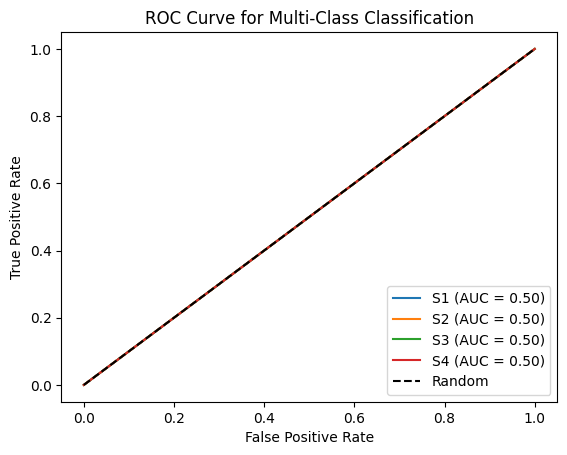

In [ ]:
calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder)

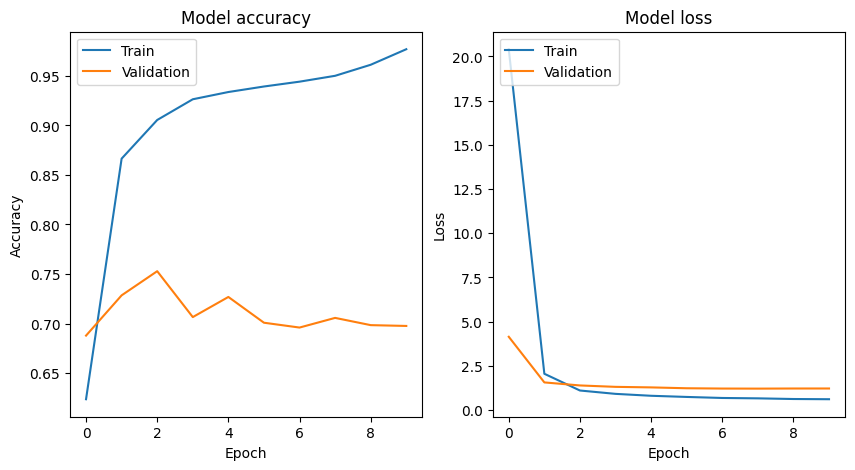

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Confusion Matrix:
    S1   S2   S3   S4
S1   9   14   30    9
S2   0  181  101   12
S3   5  154  449   63
S4   2   19   82  627


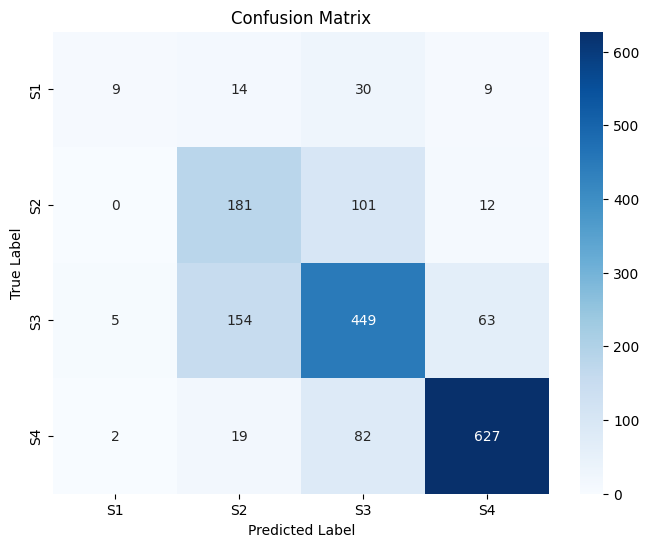

Specificity (per class): [0.9958702064896755, 0.8721804511278195, 0.8038674033149171, 0.9182083739045764]
Recall (per class): [0.14516129032258066, 0.6156462585034014, 0.669150521609538, 0.8589041095890411]
Precision (per class): [0.5625, 0.49184782608695654, 0.6782477341389728, 0.8818565400843882]
F1-score (per class): [0.2307692307692308, 0.5468277945619335, 0.6736684171042759, 0.8702290076335879]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5000
AUC-ROC for class S3: 0.5000
AUC-ROC for class S4: 0.5000


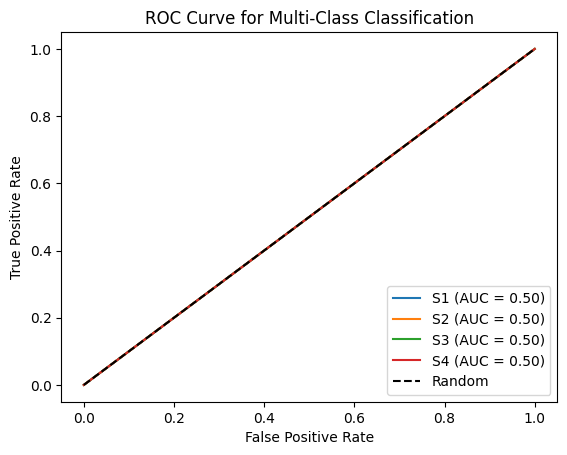

In [ ]:
calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder)

# PyCaret top 7

In [ ]:
from pycaret.classification import *

# dataset = data

# data = dataset.drop(['priority'
# ,'resolution'
# ,'product'
# ,'creation_time'
# ,'classification'
# ,'type'
# ,'last_change_time'
# ,'component'
# ,'status'
# ],axis=1)

clf1 = setup(data, target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()


,Description,Value
0,Session id,8869
1,Target,severity
2,Target type,Multiclass
3,Target mapping,"S1: 0, S2: 1, S3: 2, S4: 3"
4,Original data shape,"(4826, 3199)"
5,Transformed data shape,"(4826, 3218)"
6,Transformed train set shape,"(3378, 3218)"
7,Transformed test set shape,"(1448, 3218)"
8,Numeric features,3195
9,Categorical features,3


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8787,0.0000,0.8787,0.8612,0.8664,0.7665,0.7735
1,0.8728,0.0000,0.8728,0.8942,0.8632,0.7561,0.7707
2,0.8669,0.0000,0.8669,0.8800,0.8573,0.7438,0.7512
3,0.8698,0.0000,0.8698,0.8527,0.8565,0.7491,0.7583
4,0.8787,0.9280,0.8787,0.8905,0.8675,0.7675,0.7767
5,0.8846,0.9342,0.8846,0.8945,0.8735,0.7786,0.7861
6,0.8994,0.9531,0.8994,0.8772,0.8843,0.8065,0.8149
7,0.8935,0.9455,0.8935,0.8691,0.8782,0.7949,0.8015
8,0.9021,0.0000,0.9021,0.9118,0.8918,0.8113,0.8171


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8728,0.0000,0.8728,0.8717,0.8672,0.7578,0.7644
1,0.8462,0.0000,0.8462,0.8449,0.8372,0.7066,0.7206
2,0.8639,0.0000,0.8639,0.8520,0.8533,0.7391,0.7478
3,0.8698,0.0000,0.8698,0.8867,0.8603,0.7500,0.7606
4,0.8787,0.0000,0.8787,0.8830,0.8748,0.7703,0.7782
5,0.8876,0.0000,0.8876,0.8996,0.8765,0.7845,0.7939
6,0.8935,0.0000,0.8935,0.8806,0.8837,0.7971,0.8031
7,0.8876,0.0000,0.8876,0.8854,0.8797,0.7850,0.7895
8,0.9021,0.0000,0.9021,0.8974,0.8928,0.8117,0.8165


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8876,0.0000,0.8876,0.8853,0.8784,0.7841,0.7907
1,0.8669,0.0000,0.8669,0.8735,0.8584,0.7453,0.7582
2,0.8698,0.0000,0.8698,0.8842,0.8614,0.7501,0.7565
3,0.8669,0.0000,0.8669,0.8654,0.8582,0.7444,0.7506
4,0.8698,0.9141,0.8698,0.8759,0.8636,0.7511,0.7559
5,0.8728,0.9314,0.8728,0.8671,0.8627,0.7562,0.7614
6,0.8935,0.9457,0.8935,0.8687,0.8783,0.7948,0.8009
7,0.8905,0.9464,0.8905,0.8939,0.8788,0.7891,0.7919
8,0.8991,0.0000,0.8991,0.9083,0.8889,0.8055,0.8108


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8817,0.0000,0.8817,0.8787,0.8737,0.7735,0.7813
1,0.8373,0.0000,0.8373,0.8440,0.8361,0.6934,0.7001
2,0.8669,0.0000,0.8669,0.8570,0.8578,0.7452,0.7527
3,0.8669,0.0000,0.8669,0.8530,0.8560,0.7445,0.7519
4,0.8817,0.9403,0.8817,0.8843,0.8773,0.7759,0.7838
5,0.8728,0.9328,0.8728,0.8661,0.8638,0.7570,0.7633
6,0.9053,0.9518,0.9053,0.8998,0.8946,0.8187,0.8254
7,0.8787,0.9434,0.8787,0.8608,0.8677,0.7679,0.7719
8,0.8991,0.0000,0.8991,0.9052,0.8886,0.8051,0.8081


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8787,0.0000,0.8787,0.8816,0.8700,0.7676,0.7778
1,0.8402,0.0000,0.8402,0.8389,0.8325,0.6959,0.7074
2,0.8698,0.0000,0.8698,0.8560,0.8566,0.7495,0.7615
3,0.8669,0.0000,0.8669,0.8522,0.8537,0.7437,0.7549
4,0.8757,0.9335,0.8757,0.8900,0.8646,0.7620,0.7733
5,0.8757,0.9284,0.8757,0.8572,0.8611,0.7613,0.7718
6,0.8964,0.9477,0.8964,0.8757,0.8826,0.8012,0.8084
7,0.8787,0.9401,0.8787,0.8633,0.8679,0.7682,0.7740
8,0.9110,0.0000,0.9110,0.9211,0.9006,0.8285,0.8350


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8669,0.0000,0.8669,0.8504,0.8559,0.7442,0.7495
1,0.8402,0.0000,0.8402,0.8432,0.8356,0.6960,0.7038
2,0.8728,0.0000,0.8728,0.8663,0.8649,0.7560,0.7605
3,0.8728,0.0000,0.8728,0.8669,0.8659,0.7568,0.7617
4,0.8728,0.9461,0.8728,0.8680,0.8683,0.7590,0.7619
5,0.8817,0.9261,0.8817,0.8758,0.8762,0.7753,0.7786
6,0.8905,0.9555,0.8905,0.8642,0.8764,0.7891,0.7917
7,0.8787,0.9455,0.8787,0.8654,0.8699,0.7680,0.7700
8,0.9021,0.0000,0.9021,0.8752,0.8877,0.8102,0.8131


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8284,0.0000,0.8284,0.8263,0.8273,0.6749,0.6749
1,0.8462,0.0000,0.8462,0.8530,0.8473,0.7109,0.7143
2,0.8343,0.0000,0.8343,0.8255,0.8286,0.6830,0.6843
3,0.8580,0.0000,0.8580,0.8507,0.8527,0.7279,0.7286
4,0.8432,0.8639,0.8432,0.8481,0.8450,0.7075,0.7083
5,0.8550,0.8722,0.8550,0.8532,0.8526,0.7266,0.7289
6,0.8491,0.8608,0.8491,0.8356,0.8417,0.7115,0.7123
7,0.8817,0.8924,0.8817,0.8745,0.8773,0.7749,0.7754
8,0.8694,0.0000,0.8694,0.8624,0.8655,0.7506,0.7508


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

0
1
2
3
4
5
6


In [ ]:
# import pickle as pk
# i=0
# for m in [
#           'rf',
#           'gbc',
#           'et',
#           'xgboost',
#           'catboost',
#           'lightgbm',
#           'dt']:
#   print(model[i].get_params())
#   name=m+'.pkl'
#   with open(name, "wb") as file: # file is a variable for storing the newly created file, it can be anything.
#     pk.dump(model, file) # Dump function is used to write the object into the created file in byte format.
#   i+=1

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 8869, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 8869, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': No

# PyCaret Optimise

In [ ]:
tuned_model = tune_model(model[1])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:23:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 40,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 8853,
 'reg_alpha': 1e-06,
 'reg_lambda': 3,
 'sampling_method': None,
 'scale_pos_weight': 3.5,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [ ]:
# evaluate_model(tuned_model)

# Optimising

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Assuming X_train, X_test, y_train, y_test are already defined

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'class_weight':[None,'balanced'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=seed)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                          scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Evaluate the model with the best parameters
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate and print the metrics
# calculate_metrics(y_test, y_pred)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# dataset = mergeddata

# X = dataset.drop(['severity','priority'
# ,'resolution'
# ,'product'
# ,'creation_time'
# ,'classification'
# ,'type'
# ,'last_change_time'
# ,'component'
# ,'status'
# ,'assigned_to'
# ,'assigned_to_detail.nick'
# ,'assigned_to_detail.name'
# ,'assigned_to_detail.email'
#                 ],axis=1)

# Y = dataset['severity']

# # split data into train and test sets
# seed = 7
# test_size = 0.3
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score
# import pickle

# # model[3].save_model('xgb_model.model')

# # modelxgb = cuml.xgboost.XGBClassifier()

# # modelxgb.load_model('xgb_model.model')

# # with open('xgboost.pkl', 'rb') as f:
# #   modelxgb = pickle.load(f)

# modelxgb = model[3]

# param_grid = {
#     # 'max_depth': [3, 4, 5, 10],
#     'booster': ['dart'],
#     'max_depth': [3],
#     # 'subsample': [0.1, 0.6, 0.8, 1.0]
#     'subsample': [1.0],
#     # 'colsample_bylevel': [0.6, 0.8, 1.0]
#     'colsample_bylevel': [0.6],
#     # 'colsample_bytree': [0.6, 0.8, 1.0]
#     'colsample_bytree': [0.8],
#     # 'min_child_weight': [1, 5, 100]
#     'min_child_weight': [0.5],
#     # 'reg_alpha': [1, 5, 100],
#     # 'reg_lambda': [1, 5, 100]
#     'reg_alpha': [1],
#     'reg_lambda': [5],
#     'gamma': [0.1],
#     # 'gamma': [0, 0.1, 0.2, 0.3]
#     # 'n_estimators': [50, 100, 250, 500],
#     # 'learning_rate': [0.01, 0.2, 0.5]
#     'n_estimators': [250],
#     'learning_rate': [0.2],
#     'scale_pos_weight': [3.5],
#     # 'scale_pos_weight': [1, 5, 10],
#     'max_delta_step': [5],
#     'tree_method': ['auto']
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(
#     estimator=modelxgb,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and evaluate the model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Best Parameters: {best_params}')
# print(f'Best Model Accuracy: {accuracy:.4f}')

# Balancing techniques

In [87]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

In [88]:
data['severity'].value_counts()


,count
severity,
S4,2481
S3,2182
S2,157
S1,6


In [89]:
def resample(X_train, y_train, X_test, y_test):
    # Resampling techniques
    print('ROS')
    ros = RandomOverSampler(random_state=7)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)

    print('RUS')
    rus = RandomUnderSampler(random_state=7)
    X_rus, y_rus = rus.fit_resample(X_train, y_train)

    # Assuming X_train is your DataFrame with features
    # Identify columns with non-numerical data
    categorical_cols = X_train.select_dtypes(include=['object','category']).columns

    # Apply Label Encoding to categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        print(col)
        all_unique_values = pd.concat([X_train[col], X_test[col]]).unique()
        le.fit(all_unique_values)

        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


    print('SMOTE')
    smote = SMOTE(random_state=7, k_neighbors=2)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # print('ADASYN')
    # adasyn = ADASYN(random_state=7, sampling_strategy='minority')
    # X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

    # print('SMOTEENN')
    # smoteenn = SMOTEENN(random_state=7)
    # X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)

    return {"X_ros": X_ros, "y_ros": y_ros,
            "X_rus": X_rus, "y_rus": y_rus,
            "X_smote": X_smote, "y_smote": y_smote,
          #  "X_adasyn": X_adasyn, "y_adasyn": y_adasyn,
          #  "X_smoteenn": X_smoteenn, "y_smoteenn": y_smoteenn,
            "X_train": X_train, "X_test": X_test}



In [90]:
resampled= resample(X_train, y_train, X_test, y_test)

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names


ROS
RUS
SMOTE


# Resampled run

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Accuracy: 0.8840
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   4   48    0
S3   0   2  622   22
S4   0   1   93  654


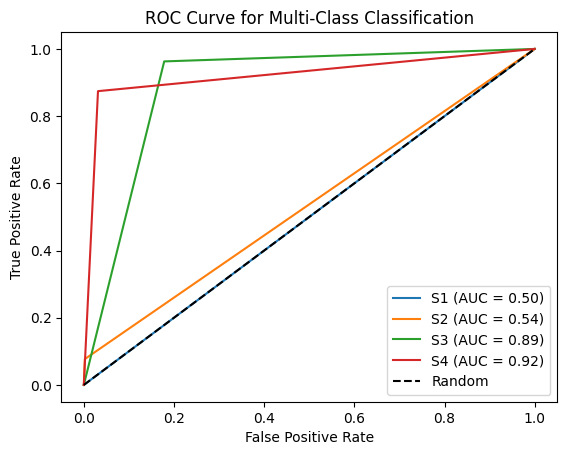

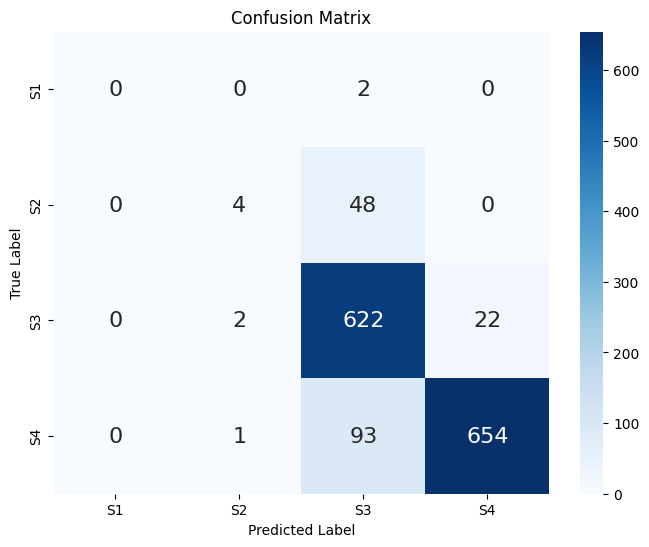

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.500000     1.000000  0.000000   0.000000  0.000000
1             S2  0.537387     0.997851  0.076923   0.571429  0.135593
2             S3  0.892272     0.821696  0.962848   0.813072  0.881644
3             S4  0.921451     0.968571  0.874332   0.967456  0.918539
4  Total/Average  0.712778     0.947030  0.883978   0.883022  0.872694
Overall Accuracy: 0.7638
Confusion Matrix:
    S1   S2   S3   S4
S1   0    1    1    0
S2   7    8   37    0
S3  30  111  473   32
S4   3   14  106  625


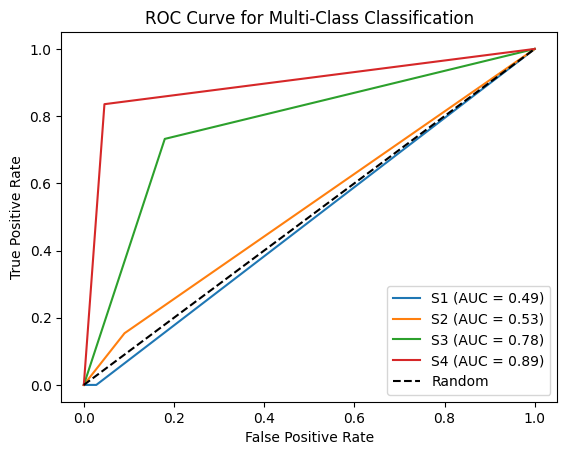

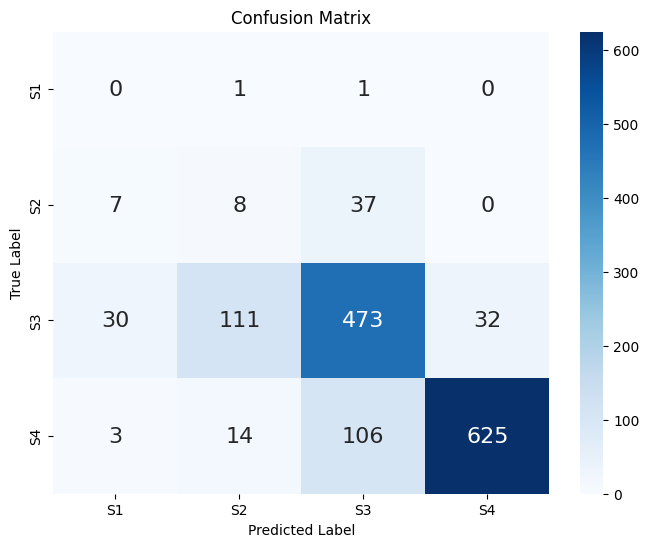

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.486169     0.972337  0.000000   0.000000  0.000000
1             S2  0.531794     0.909742  0.153846   0.059701  0.086022
2             S3  0.776324     0.820449  0.732198   0.766613  0.749010
3             S4  0.894924     0.954286  0.835561   0.951294  0.889680
4  Total/Average  0.672302     0.914204  0.763812   0.835569  0.796833
Overall Accuracy: 0.8564
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   9   43    0
S3   2  50  569   25
S4   0  10   76  662


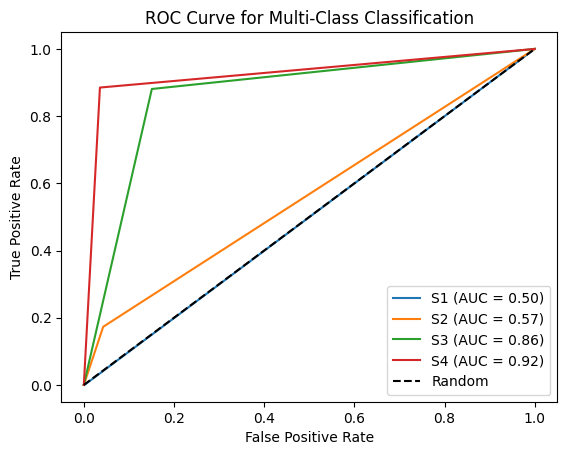

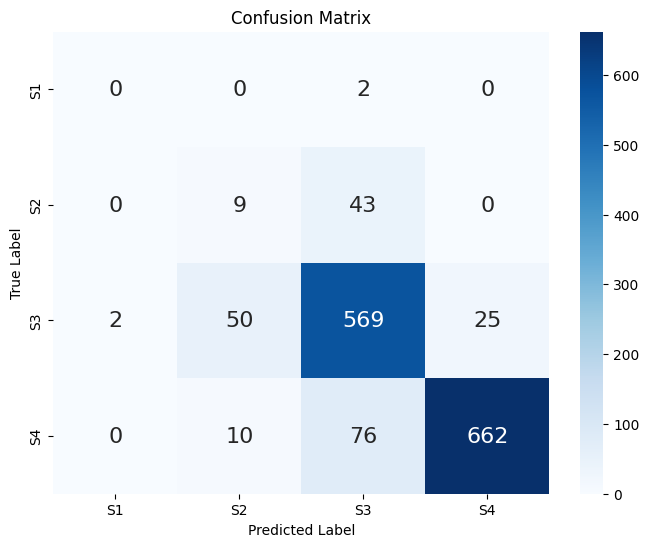

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.499308     0.998617  0.000000   0.000000  0.000000
1             S2  0.565048     0.957020  0.173077   0.130435  0.148760
2             S3  0.864966     0.849127  0.880805   0.824638  0.851796
3             S4  0.924656     0.964286  0.885027   0.963610  0.922648
4  Total/Average  0.713495     0.942262  0.856354   0.870358  0.861973


NameError: name 'run_xgboost' is not defined

In [67]:
y_pred = run_rf(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_rf(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_rf(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_rf(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_rf(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)


[0]	train-mlogloss:1.18356
[99]	train-mlogloss:0.20206
Accuracy: 0.8439226519337016
Recall: 0.8439226519337016
Precision: 0.8834735953001773
F1 Score: 0.8604066937790272
Cohen's Kappa: 0.7202123748535862
MCC: 0.7240292340603997
Overall Accuracy: 0.8439
Confusion Matrix:
    S1  S2   S3   S4
S1   0   2    0    0
S2   0  26   25    1
S3   0  82  537   27
S4   0  22   67  659


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


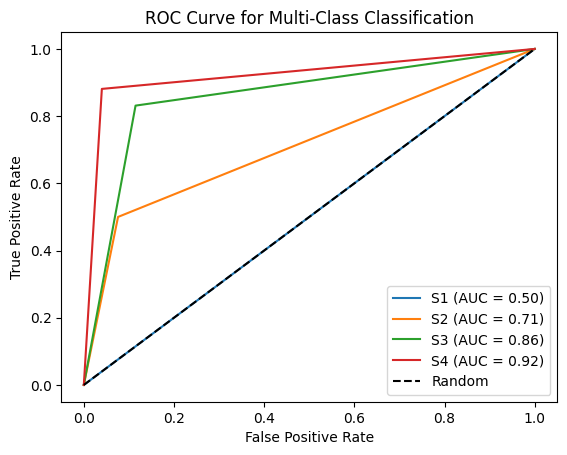

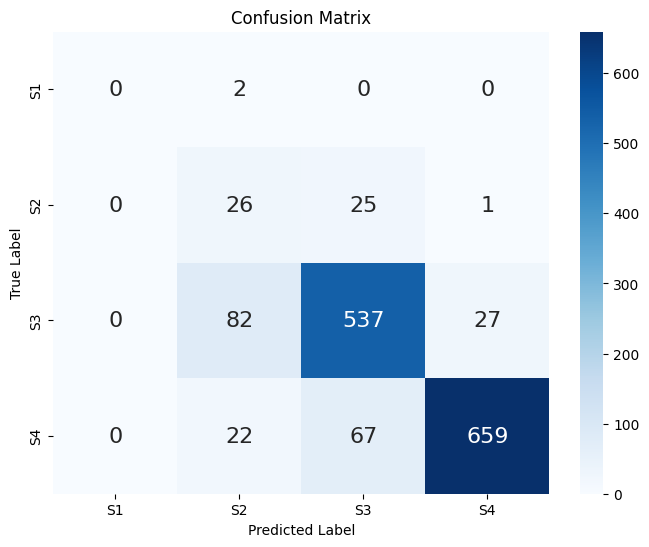

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.500000     1.000000  0.000000   0.000000  0.000000
1             S2  0.712034     0.924069  0.500000   0.196970  0.282609
2             S3  0.858278     0.885287  0.831269   0.853736  0.842353
3             S4  0.920508     0.960000  0.881016   0.959243  0.918467
4  Total/Average  0.747705     0.942339  0.843923   0.883474  0.860407
[0]	train-mlogloss:1.34153
[99]	train-mlogloss:0.69034
Accuracy: 0.5897790055248618
Recall: 0.5897790055248618
Precision: 0.750741850375271
F1 Score: 0.6377965100276175
Cohen's Kappa: 0.32125107125777885
MCC: 0.34118776835211245
Overall Accuracy: 0.5898
Confusion Matrix:
    S1   S2   S3   S4
S1   0    0    2    0
S2   4    8   40    0
S3  36  164  432   14
S4   5   31  298  414


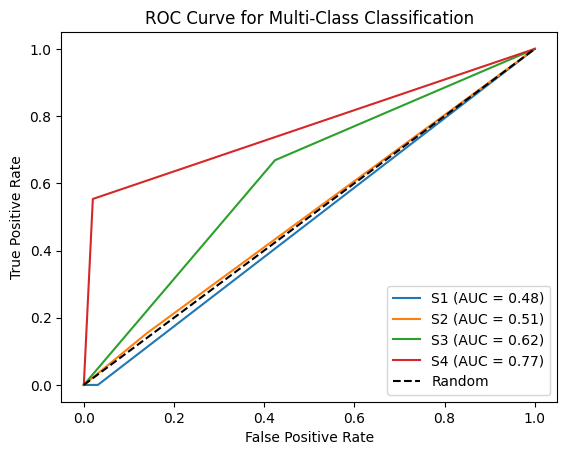

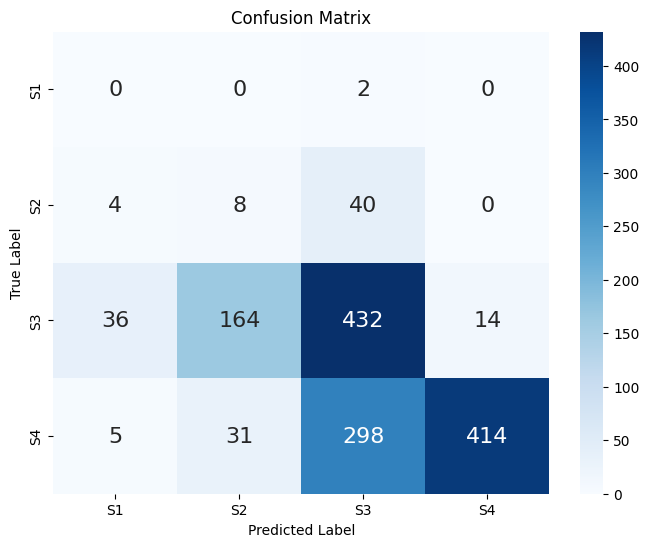

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.484440     0.968880  0.000000   0.000000  0.000000
1             S2  0.507081     0.860315  0.153846   0.039409  0.062745
2             S3  0.622395     0.576060  0.668731   0.559585  0.609309
3             S4  0.766738     0.980000  0.553476   0.967290  0.704082
4  Total/Average  0.595163     0.846314  0.589779   0.750742  0.637797
[0]	train-mlogloss:1.21430
[99]	train-mlogloss:0.30347
Accuracy: 0.8349447513812155
Recall: 0.8349447513812155
Precision: 0.87795390054778
F1 Score: 0.8535014309186
Cohen's Kappa: 0.7042675736186358
MCC: 0.7080935568352241
Overall Accuracy: 0.8349
Confusion Matrix:
    S1  S2   S3   S4
S1   0   1    1    0
S2   2  20   30    0
S3   5  89  534   18
S4   0  13   80  655


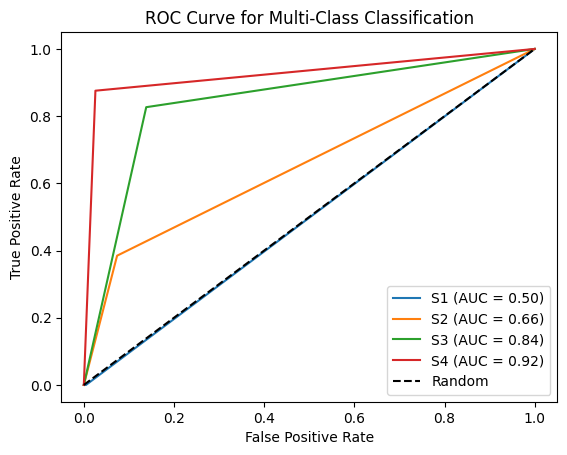

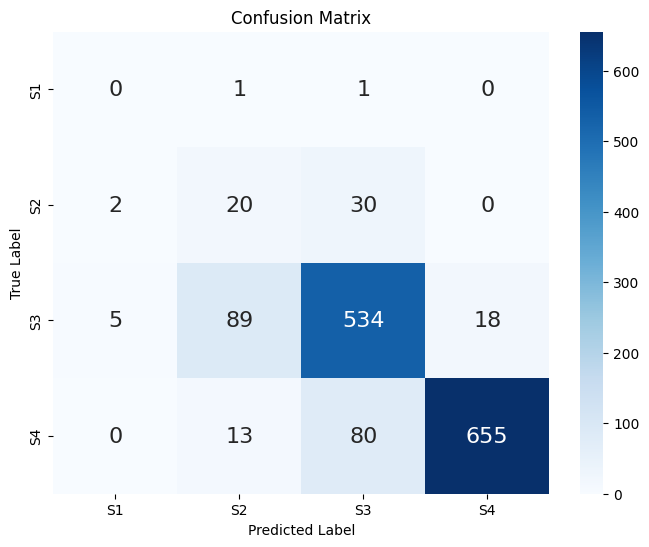

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.497580     0.995159  0.000000   0.000000  0.000000
1             S2  0.655417     0.926218  0.384615   0.162602  0.228571
2             S3  0.844111     0.861596  0.826625   0.827907  0.827266
3             S4  0.924977     0.974286  0.875668   0.973254  0.921886
4  Total/Average  0.730521     0.939315  0.834945   0.877954  0.853501


KeyError: 'X_adasyn'

In [77]:
y_pred = run_xgboost(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_xgboost(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_xgboost(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

run_xgboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

run_xgboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

In [ ]:
y_pred = run_lightgbm(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_lightgbm(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_lightgbm(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_lightgbm(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_lightgbm(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


Overall Accuracy: 0.8267
Confusion Matrix:
    S1   S2   S3   S4
S1   0    2    0    0
S2   1   33   18    0
S3   3  118  509   16
S4   0   18   75  655


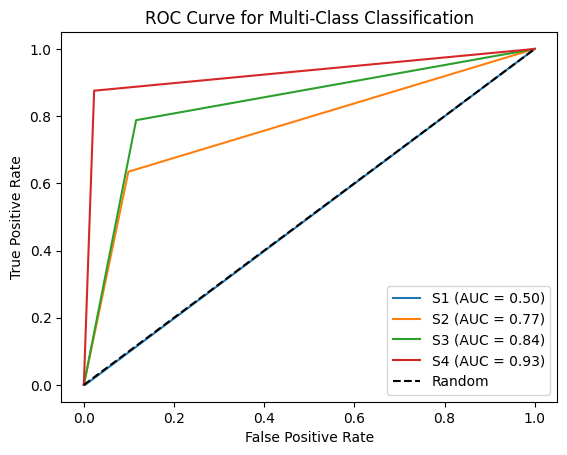

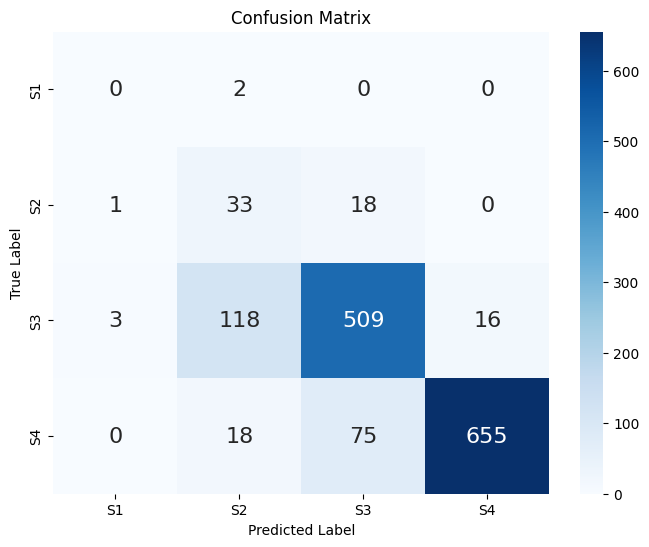

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.498617     0.997234  0.000000   0.000000  0.000000
1             S2  0.767881     0.901146  0.634615   0.192982  0.295964
2             S3  0.835983     0.884040  0.787926   0.845515  0.815705
3             S4  0.926406     0.977143  0.875668   0.976155  0.923185
4  Total/Average  0.757222     0.939891  0.826657   0.888399  0.851435
Overall Accuracy: 0.6229
Confusion Matrix:
    S1   S2   S3   S4
S1   1    0    1    0
S2   2   18   27    5
S3  20  148  231  247
S4   1   16   79  652


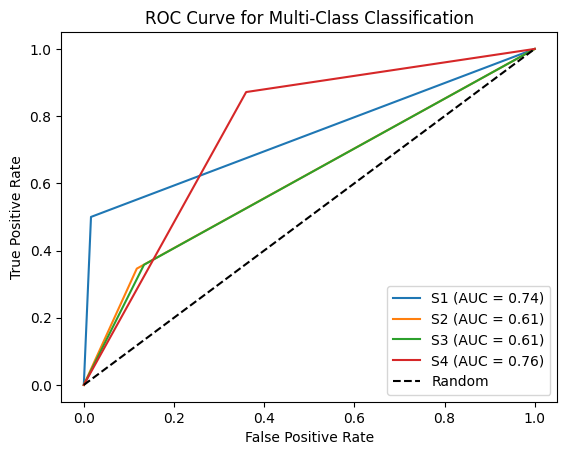

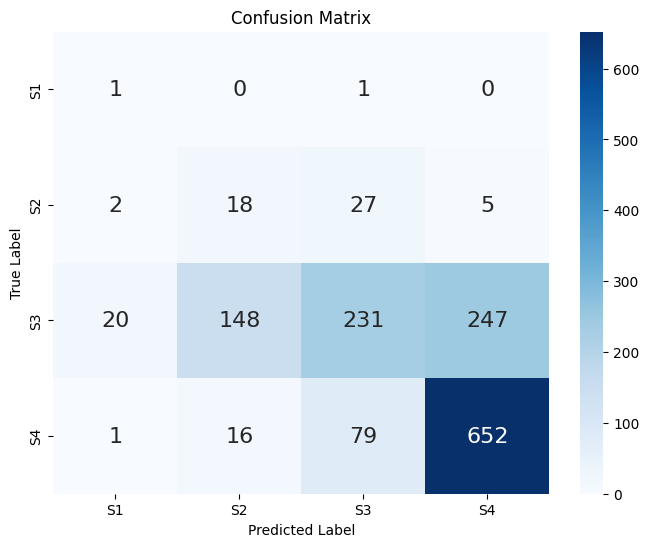

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.742047     0.984094  0.500000   0.041667  0.076923
1             S2  0.614338     0.882521  0.346154   0.098901  0.153846
2             S3  0.612084     0.866584  0.357585   0.683432  0.469512
3             S4  0.755829     0.640000  0.871658   0.721239  0.789346
4  Total/Average  0.681074     0.843300  0.622928   0.681084  0.622852
Overall Accuracy: 0.8432
Confusion Matrix:
    S1  S2   S3   S4
S1   1   0    1    0
S2   3  23   26    0
S3   3  86  542   15
S4   1  11   81  655


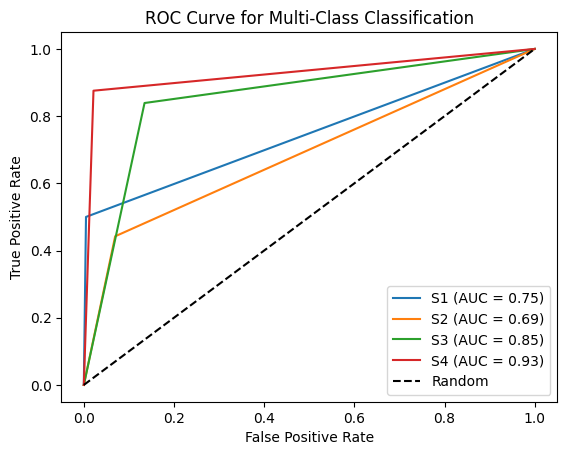

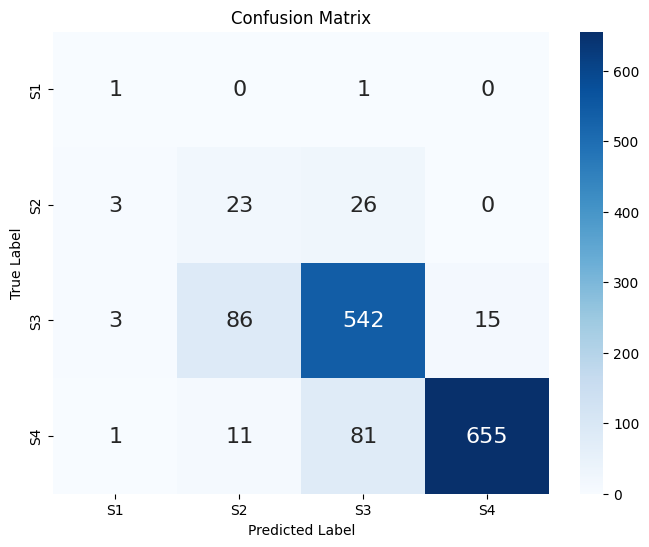

           Class   AUC-ROC  Specificity    Recall  Precision  F1-score
0             S1  0.747580     0.995159  0.500000   0.125000  0.200000
1             S2  0.686412     0.930516  0.442308   0.191667  0.267442
2             S3  0.852173     0.865337  0.839009   0.833846  0.836420
3             S4  0.927120     0.978571  0.875668   0.977612  0.923836
4  Total/Average  0.803321     0.942396  0.843232   0.884071  0.860265


KeyError: 'X_adasyn'

In [92]:
y_pred = run_catboost(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_catboost(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

y_pred = run_catboost(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

run_catboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)

run_catboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics_table(y_test, y_pred, class_names=class_names)


In [ ]:
y_pred = run_gradient_boosting(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_gradient_boosting(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_gradient_boosting(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_gradient_boosting(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_gradient_boosting(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


In [ ]:
y_pred = run_et(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_et(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_et(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_xgboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_xgboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


In [ ]:
y_pred = run_dt(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_dt(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_dt(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_dt(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_dt(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


In [ ]:
model, history, X_test_processed, y_test, label_encoder, y_pred = run_mlp(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder)

model, history, X_test_processed, y_test, label_encoder, y_pred = run_mlp(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder)

model, history, X_test_processed, y_test, label_encoder, y_pred = run_mlp(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder)

run_catboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

run_catboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


# Heatmap

In [ ]:
# mergeddataS = dmergeddata
mergeddataS = dmergeddata[dmergeddata.columns.drop(list(dmergeddata.filter(regex='^Psummary')))]
mergeddataS = mergeddataS[mergeddataS.columns.drop(list(mergeddataS.filter(regex='^component')))]
mergeddataS = mergeddataS.drop(['product_Core','classification_Components'],axis=1)
mergeddataP = dmergeddata[list(dmergeddata.filter(regex='^Psummary'))]

In [ ]:
print(mergeddataS.columns.tolist())
print(mergeddataP.columns.tolist())

['id', 'severity', 'version', 'assigned_to_detail.id', 'resolution_', 'resolution_DUPLICATE', 'resolution_FIXED', 'resolution_INCOMPLETE', 'resolution_INVALID', 'resolution_WONTFIX', 'resolution_WORKSFORME', 'type_defect', 'type_enhancement', 'type_task']
['Psummary_intermittent', 'Psummary_bug', 'Psummary_tracking', 'Psummary_single', 'Psummary_sync', 'Psummary_pr', 'Psummary_wptsync', 'Psummary_test', 'Psummary_wpt', 'Psummary_tier', 'Psummary_failure', 'Psummary_add', 'Psummary_crash', 'Psummary_firefox', 'Psummary_code', 'Psummary_new', 'Psummary_remove', 'Psummary_fix', 'Psummary_update', 'Psummary_failing', 'Psummary_args', 'Psummary_assertion', 'Psummary_nt', 'Psummary_http', 'Psummary_implement', 'Psummary_support', 'Psummary_unknown', 'Psummary_window', 'Psummary_mozilla', 'Psummary_use', 'Psummary_video', 'Psummary_page', 'Psummary_error', 'Psummary_set', 'Psummary_meta', 'Psummary_text', 'Psummary_perma', 'Psummary_using', 'Psummary_element', 'Psummary_file', 'Psummary_work'

In [ ]:
summary.drop(axis=1, columns=['Unnamed: 0','nindex','index'], inplace=True)
summary.head()

data['Psummary']=data['Psummary'].tolist()

data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))


from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df,col):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df[col])

    # Select the first five documents from the data set
    tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
    tf_idf.columns = vectorizer.get_feature_names_out()
    tfidf_matrix = tf_idf.T
    tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, 10001)]
    tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

    # Top words
    tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

    # Print the first 10 words
    # print(tfidf_matrix.drop(columns=['count']).head(10))

    return tfidf_matrix

# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

filter='^\d+$'
notfilter='^(?!'+filter+').*$'
wordlst = over1.loc[over1.index.str.contains(notfilter)]

wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

summary = summary[wordlst['words']]
summary.head()

mergeddata = pd.concat([data,summary],axis=1)

mergeddata.to_csv('dataset_20240907_plusP_Psummary_tfidf_10.csv')

In [ ]:
# Assuming you have your DataFrame loaded as 'dataHM'

# Get all columns
all_columns = mergeddataS.columns.tolist()

# Get numerical columns
numerical_columns = mergeddataS.select_dtypes(include=['number']).columns.tolist()

# Get non-numerical columns
non_numerical_columns = list(set(all_columns) - set(numerical_columns))

print("Columns that cannot be converted to float:", non_numerical_columns)

Columns that cannot be converted to float: ['resolution', 'status', 'creation_time', 'last_change_time', 'classification', 'component', 'type', 'product']


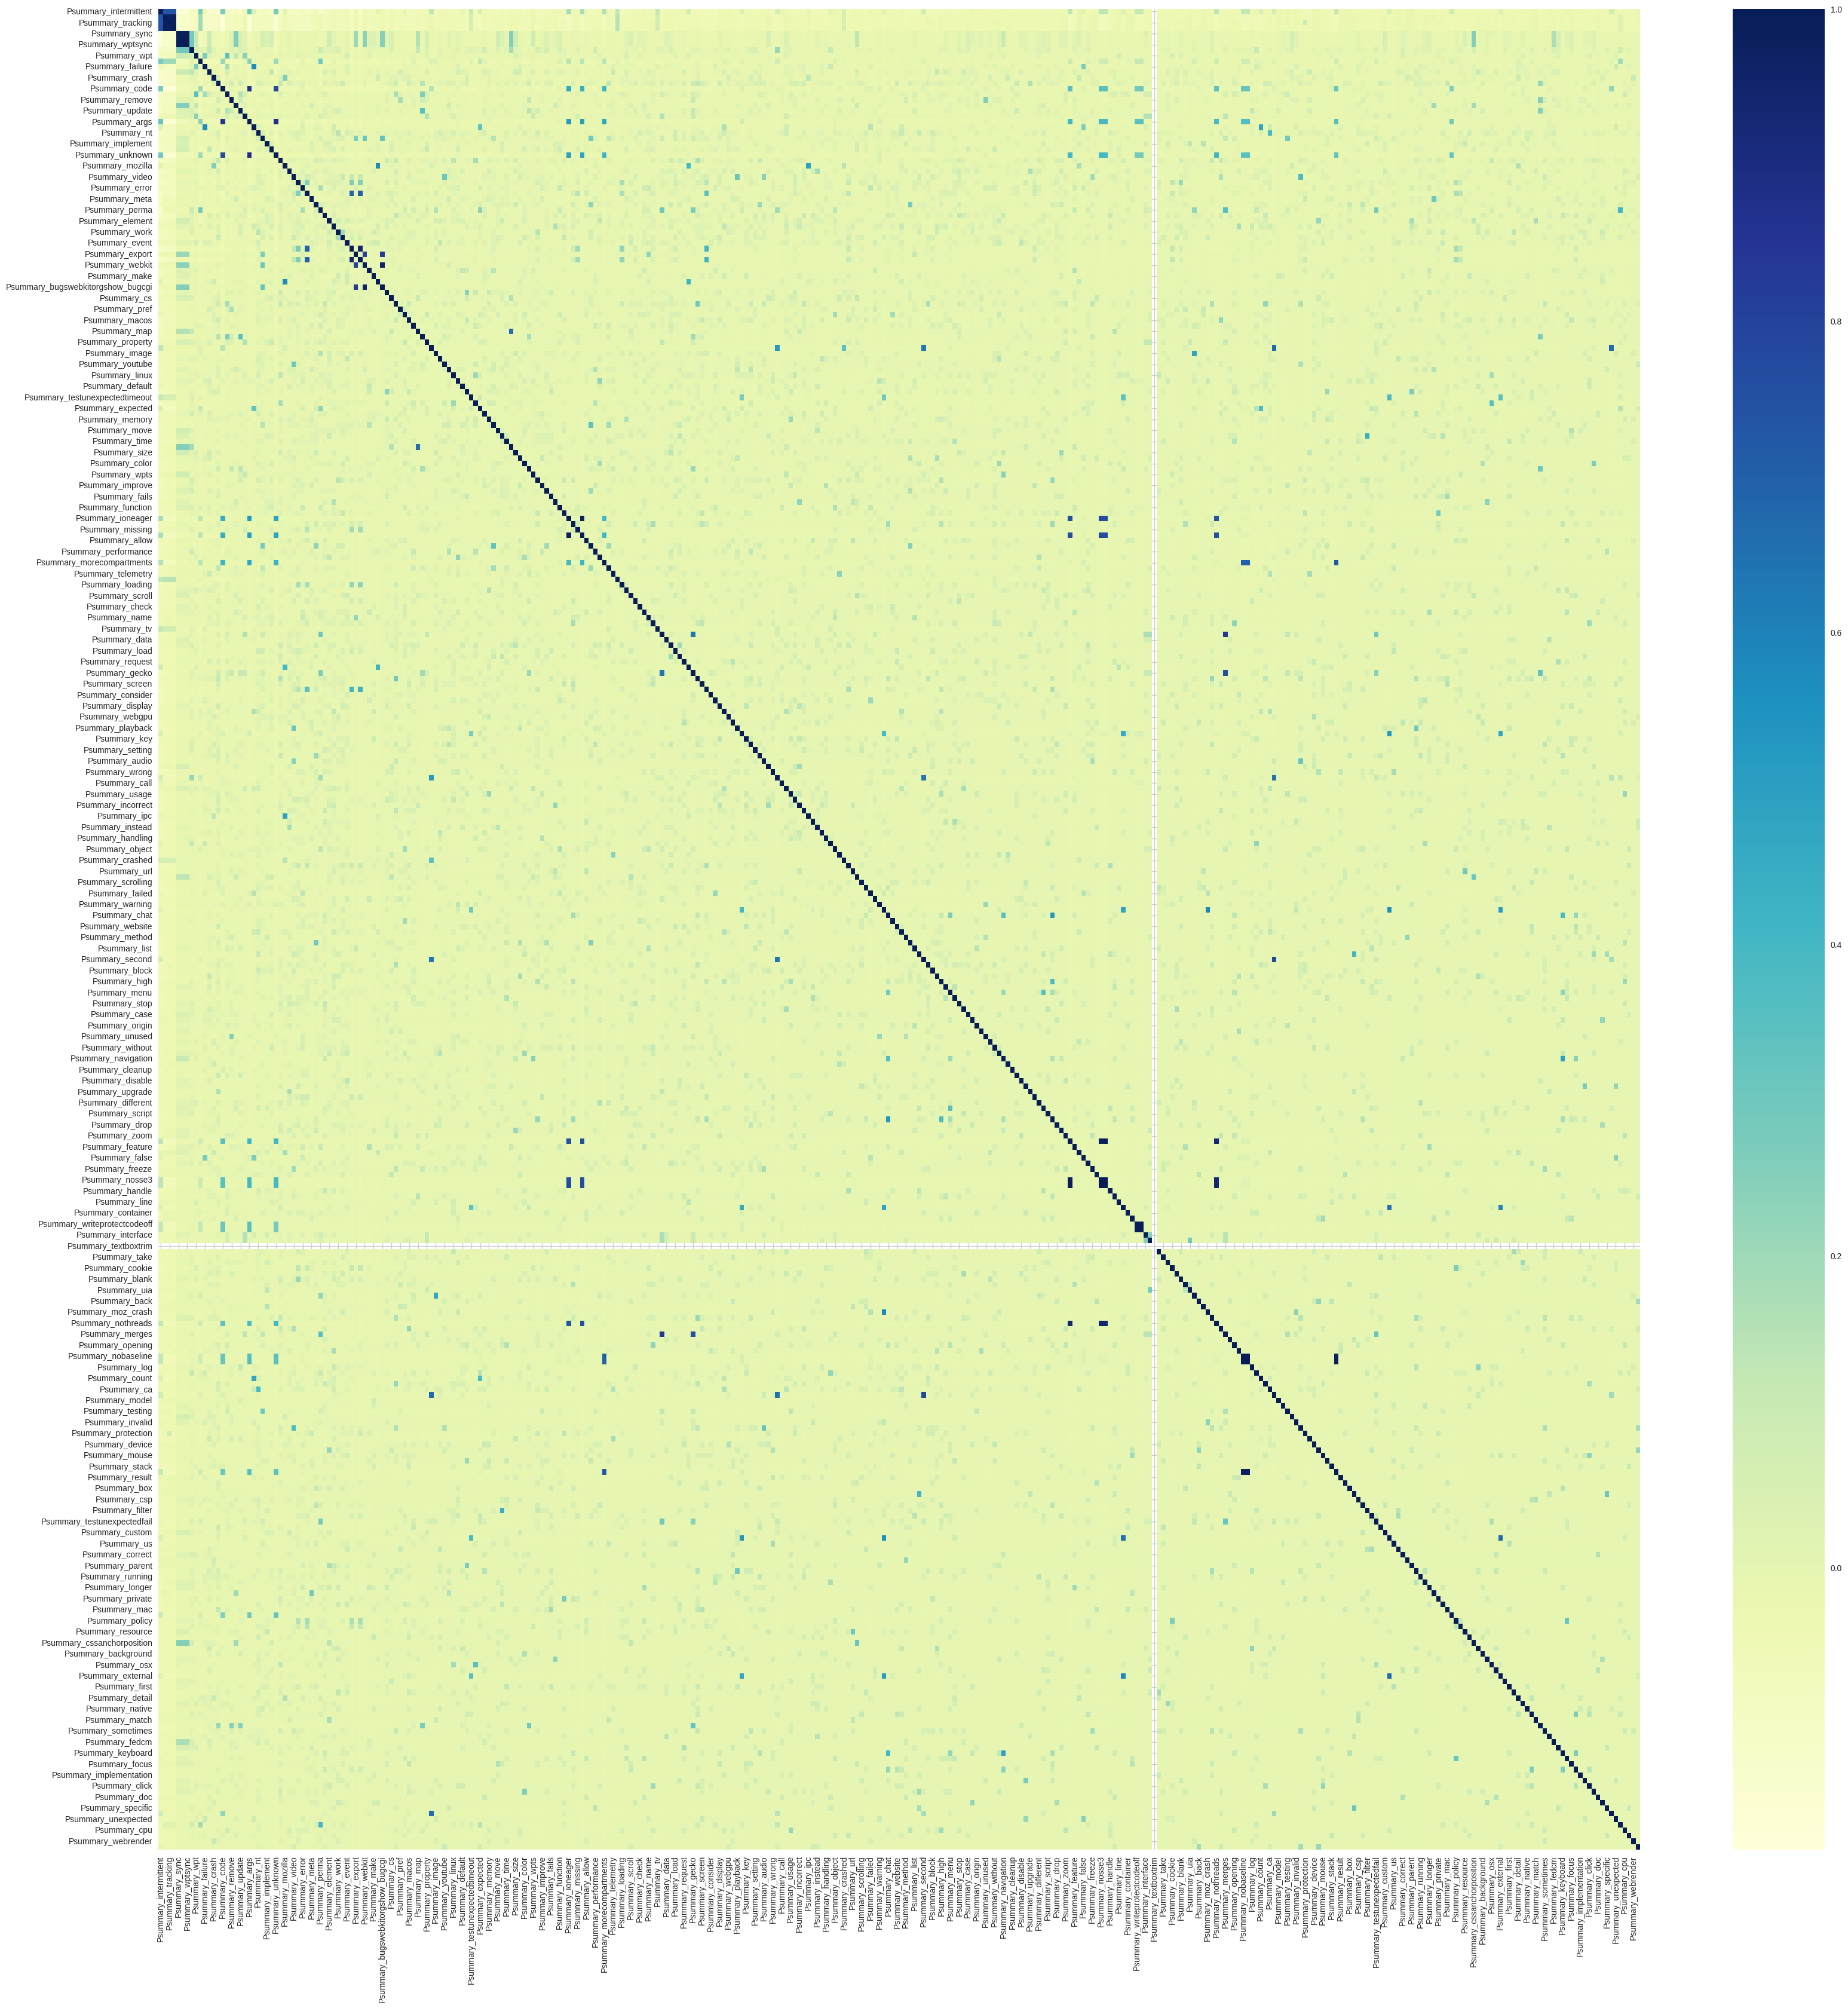

In [ ]:
# Import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# Import file with data
dataHM = mergeddataP.copy()
# mergeddata[mergeddata.columns.drop(list(mergeddata.filter(regex='^Psummary')))]

# Print data that will be plotted
# Columns shown here are selected by corr() since
# they are ideal for the plot
# print(dataHM.corr(numeric_only=True))

# Plotting correlation heatmap
fig, ax = mp.subplots(figsize=(40, 40))
dataplot = sb.heatmap(dataHM.corr(numeric_only=True), cmap="YlGnBu", annot=False, ax=ax)

# Displaying heatmap
mp.show()


In [ ]:
threshold = 0.005
correlations = mergeddataS.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = mergeddataS[selected_features]

severity                 1.000000
type_defect              0.457767
type_task                0.373556
version                  0.350471
type_enhancement         0.216913
resolution_INCOMPLETE    0.115843
resolution_WORKSFORME    0.076393
resolution_              0.067771
id                       0.062608
resolution_INVALID       0.055402
resolution_WONTFIX       0.040366
resolution_DUPLICATE     0.017682
assigned_to_detail.id    0.010912
resolution_FIXED         0.006552
Name: severity, dtype: float64
Index(['severity', 'type_defect', 'type_task', 'version', 'type_enhancement',
       'resolution_INCOMPLETE', 'resolution_WORKSFORME', 'resolution_', 'id',
       'resolution_INVALID', 'resolution_WONTFIX', 'resolution_DUPLICATE',
       'assigned_to_detail.id', 'resolution_FIXED'],
      dtype='object')


In [ ]:
threshold = 0.005
mergeddataP['severity'] = mergeddataS['severity']
correlations = mergeddataP.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = pd.concat([mergeddata,mergeddataP[selected_features]])

severity                 1.000000
Psummary_intermittent    0.131275
Psummary_crash           0.126663
Psummary_strict          0.125892
Psummary_etp             0.117092
                           ...   
Psummary_time            0.000342
Psummary_gc              0.000163
Psummary_expose          0.000147
Psummary_custom          0.000104
Psummary_textboxtrim          NaN
Name: severity, Length: 335, dtype: float64
Index(['severity', 'Psummary_intermittent', 'Psummary_crash',
       'Psummary_strict', 'Psummary_etp', 'Psummary_probe', 'Psummary_page',
       'Psummary_set', 'Psummary_video', 'Psummary_displayed',
       ...
       'Psummary_wb', 'Psummary_policy', 'Psummary_thread',
       'Psummary_function', 'Psummary_call', 'Psummary_second',
       'Psummary_beta', 'Psummary_message', 'Psummary_instead',
       'Psummary_issue'],
      dtype='object', length=301)


In [ ]:
mergeddata.columns.tolist()

['severity',
 'type_defect',
 'type_task',
 'version',
 'type_enhancement',
 'resolution_INCOMPLETE',
 'resolution_WORKSFORME',
 'resolution_',
 'id',
 'resolution_INVALID',
 'resolution_WONTFIX',
 'resolution_DUPLICATE',
 'assigned_to_detail.id',
 'resolution_FIXED',
 'Psummary_intermittent',
 'Psummary_crash',
 'Psummary_strict',
 'Psummary_etp',
 'Psummary_probe',
 'Psummary_page',
 'Psummary_set',
 'Psummary_video',
 'Psummary_displayed',
 'Psummary_single',
 'Psummary_tracking',
 'Psummary_bug',
 'Psummary_add',
 'Psummary_enabled',
 'Psummary_keyboard',
 'Psummary_meta',
 'Psummary_button',
 'Psummary_nt',
 'Psummary_telemetry',
 'Psummary_remove',
 'Psummary_failure',
 'Psummary_sidebar',
 'Psummary_code',
 'Psummary_firefox',
 'Psummary_element',
 'Psummary_window',
 'Psummary_mac',
 'Psummary_loading',
 'Psummary_does_not',
 'Psummary_navigation',
 'Psummary_string',
 'Psummary_stop',
 'Psummary_macos',
 'Psummary_chat',
 'Psummary_scroll',
 'Psummary_audio',
 'Psummary_script

In [ ]:
from pycaret.classification import *

data = mergeddata

clf1 = setup(data.reset_index(drop=True), target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()

,Description,Value
0,Session id,7695
1,Target,severity
2,Target type,Multiclass
3,Original data shape,"(8218, 69)"
4,Transformed data shape,"(8218, 69)"
5,Transformed train set shape,"(5752, 69)"
6,Transformed test set shape,"(2466, 69)"
7,Numeric features,58
8,Categorical features,10
9,Rows with missing values,100.0%


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6736,0.8473,0.6736,0.6864,0.6766,0.4765,0.4793
1,0.7240,0.8711,0.7240,0.7304,0.7222,0.5562,0.5610
2,0.6539,0.0000,0.6539,0.6750,0.6564,0.4467,0.4523
3,0.7061,0.0000,0.7061,0.7137,0.7048,0.5255,0.5302
4,0.6974,0.0000,0.6974,0.7076,0.6983,0.5134,0.5173
5,0.6904,0.0000,0.6904,0.7036,0.6902,0.5006,0.5067
6,0.7078,0.8618,0.7078,0.7196,0.7057,0.5265,0.5328
7,0.7043,0.8767,0.7043,0.7078,0.7032,0.5227,0.5252
8,0.6817,0.8465,0.6817,0.6973,0.6833,0.4920,0.4970


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.0000,0.7118,0.7153,0.7094,0.5344,0.5383
1,0.7587,0.0000,0.7587,0.7567,0.7544,0.6107,0.6143
2,0.6991,0.0000,0.6991,0.7101,0.6999,0.5207,0.5258
3,0.7217,0.0000,0.7217,0.7221,0.7194,0.5494,0.5517
4,0.7026,0.0000,0.7026,0.7191,0.7047,0.5280,0.5346
5,0.7130,0.0000,0.7130,0.7265,0.7140,0.5428,0.5490
6,0.7096,0.0000,0.7096,0.7241,0.7086,0.5316,0.5392
7,0.7391,0.0000,0.7391,0.7574,0.7365,0.5766,0.5795
8,0.7130,0.0000,0.7130,0.7236,0.7133,0.5433,0.5486


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6684,0.8277,0.6684,0.6875,0.6733,0.4706,0.4743
1,0.7257,0.8492,0.7257,0.7306,0.7231,0.5580,0.5628
2,0.6574,0.0000,0.6574,0.6756,0.6595,0.4529,0.4582
3,0.6904,0.0000,0.6904,0.7028,0.6911,0.5017,0.5067
4,0.6748,0.0000,0.6748,0.6977,0.6813,0.4816,0.4857
5,0.6904,0.0000,0.6904,0.7068,0.6922,0.5022,0.5078
6,0.6957,0.8578,0.6957,0.7173,0.6974,0.5103,0.5176
7,0.7009,0.8664,0.7009,0.7109,0.7019,0.5183,0.5216
8,0.6887,0.8356,0.6887,0.7074,0.6915,0.5047,0.5106


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.8684,0.7118,0.7102,0.7079,0.5320,0.5348
1,0.7500,0.8991,0.7500,0.7425,0.7438,0.5941,0.5967
2,0.6957,0.0000,0.6957,0.7068,0.6959,0.5120,0.5153
3,0.7235,0.0000,0.7235,0.7218,0.7192,0.5492,0.5521
4,0.6974,0.0000,0.6974,0.7157,0.6983,0.5166,0.5249
5,0.7183,0.0000,0.7183,0.7295,0.7182,0.5483,0.5542
6,0.7096,0.8728,0.7096,0.7236,0.7088,0.5293,0.5354
7,0.7391,0.8959,0.7391,0.7376,0.7348,0.5770,0.5806
8,0.7200,0.8777,0.7200,0.7302,0.7197,0.5509,0.5545


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7188,0.8723,0.7188,0.7099,0.7127,0.5425,0.5442
1,0.7552,0.9012,0.7552,0.7429,0.7471,0.6008,0.6028
2,0.6957,0.0000,0.6957,0.6973,0.6935,0.5115,0.5148
3,0.7322,0.0000,0.7322,0.7275,0.7273,0.5640,0.5665
4,0.6991,0.0000,0.6991,0.7072,0.6986,0.5176,0.5224
5,0.7096,0.0000,0.7096,0.7182,0.7088,0.5336,0.5389
6,0.7078,0.8795,0.7078,0.7166,0.7052,0.5244,0.5299
7,0.7322,0.8939,0.7322,0.7256,0.7266,0.5640,0.5663
8,0.7113,0.8809,0.7113,0.7119,0.7087,0.5361,0.5392


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7049,0.8645,0.7049,0.7067,0.7034,0.5234,0.5255
1,0.7483,0.8938,0.7483,0.7421,0.7433,0.5914,0.5932
2,0.6991,0.0000,0.6991,0.7232,0.7004,0.5170,0.5200
3,0.7357,0.0000,0.7357,0.7351,0.7311,0.5700,0.5738
4,0.7113,0.0000,0.7113,0.7239,0.7117,0.5362,0.5418
5,0.7148,0.0000,0.7148,0.7282,0.7155,0.5437,0.5498
6,0.7078,0.8706,0.7078,0.7190,0.7056,0.5250,0.5307
7,0.7443,0.8895,0.7443,0.7475,0.7417,0.5878,0.5921
8,0.7096,0.8769,0.7096,0.7242,0.7098,0.5348,0.5402


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7832,0.6667,0.6846,0.6717,0.4667,0.4696
1,0.7205,0.7997,0.7205,0.7357,0.7217,0.5506,0.5557
2,0.6557,0.0000,0.6557,0.6741,0.6593,0.4518,0.4566
3,0.6887,0.0000,0.6887,0.7022,0.6902,0.4976,0.5019
4,0.6800,0.0000,0.6800,0.7063,0.6859,0.4905,0.4965
5,0.6957,0.0000,0.6957,0.7166,0.6999,0.5114,0.5163
6,0.6870,0.8107,0.6870,0.7062,0.6885,0.4934,0.4988
7,0.6904,0.8078,0.6904,0.7049,0.6935,0.5033,0.5068
8,0.6887,0.8023,0.6887,0.7044,0.6907,0.5020,0.5071


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

0
1
2
3
4
5
6


# Something else

In [ ]:
data = dummies(data,'component')
# data, lemodel = lencoder(data,'priority')
data, lemodel = lencoder(data,'severity')
data, lemodel = lencoder(data,'version')
# data['creation_time'] = pd.to_datetime(data['creation_time'])
# data['last_change_time'] = pd.to_datetime(data['last_change_time'])
data['assigned_to_detail.id'] = data['assigned_to_detail.id']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer # Import TF-IDF vectorizer

# 1. Prepare Data
X = data.drop(['severity',
               'component',
                'status'
               ],axis=1)
               # Target variable
                # 'priority', 'resolution', 'product', 'creation_time',
                # 'classification', 'type', 'last_change_time',
                #'assigned_to', 'assigned_to_detail.nick',
                # 'assigned_to_detail.name', 'assigned_to_detail.email'],
Y = dataset['severity']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

# Assuming 'Pdescription' column contains the text data
text_column = 'Pdescription'

# 2. Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# 3. Fit and Transform Training Data
X_train_text = vectorizer.fit_transform(X_train[text_column].astype(str)) # Convert to string if necessary

# 4. Transform Test Data
X_test_text = vectorizer.transform(X_test[text_column].astype(str))

# 5. Replace Text Column with TF-IDF Features in X_train and X_test
X_train = X_train.drop(text_column, axis=1)
X_train_text_df = pd.DataFrame(X_train_text.toarray())
X_train_text_df.columns = [f'tfidf_{i}' for i in range(X_train_text_df.shape[1])] # Give string column names to TF-IDF features
X_train = pd.concat([X_train, X_train_text_df], axis=1)

X_test = X_test.drop(text_column, axis=1)
X_test_text_df = pd.DataFrame(X_test_text.toarray())
X_test_text_df.columns = [f'tfidf_{i}' for i in range(X_test_text_df.shape[1])] # Give string column names to TF-IDF features
X_test = pd.concat([X_test, X_test_text_df], axis=1)

# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# 6. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=5, random_state=7)
rf_model.fit(X_train, y_train)

# 3. Generate Pseudo-Labels
rf_probs = rf_model.predict_proba(X_test)
pseudo_labels = [np.argmax(prob) if max(prob) > 0.8 else -1 for prob in rf_probs]

# 4. Combine Data
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, pd.Series(pseudo_labels)])
mask = y_combined != -1
X_combined = X_combined[mask]
y_combined = y_combined[mask]

# Ensure all column names in X_combined are strings
X_combined.columns = X_combined.columns.astype(str)


# 5. Train LightGBM
lgbm_model = LGBMClassifier(n_estimators=100, random_state=7)
lgbm_model.fit(X_combined, y_combined)

# Evaluation
y_pred = lgbm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")